In [1]:
# This is the main file for the implementation of volatility managed portfolios
# As part of the Master Project for the Msc in Financial Engineering at EDHEC Buusiness School
# Property of Wiktor Kotwicki, Moana Valdenaire, and Nicolas Gamboa Alvarez
# EDHEC Business School, 2024-2025

In [2]:
# TODO's:
# URGENTS:
# Enhance the volatility managed portfolio construction: Tackle the issue of C
# For both the Future and the Strategy classes, add functions that estimate the transaction costs for a transaction
# Add a function to the Strategy class that estimates the most efficient transaction (i.e. if we rebalance, we don't sell all and then buy back, we buy or sell the difference)
# Implement also GMV and maybe Max Sharpe as possible benchmark strategies

In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import portfolio_builder as pb
import pickle

In [4]:
# Desabling warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Reading the futures and contracts to a pickle file
# Under 'outputs/futures'
with open('outputs/futures/futures_euroindex.pkl', 'rb') as f:
    futures_euroindex = pickle.load(f)
with open('outputs/futures/futures_metals.pkl', 'rb') as f:
    futures_metals = pickle.load(f)

In [6]:
# Reading the futures and contracts to a pickle file
# Under 'outputs/futures'
for future in futures_euroindex:
    with open(f'outputs/futures/{future.name}.pkl', 'wb') as f:
        pickle.dump(future, f)
        print(f"Future {future.name} saved successfully.")
for future in futures_metals:
    with open(f'outputs/futures/{future.name}.pkl', 'wb') as f:
        pickle.dump(future, f)
        print(f"Future {future.name} saved successfully.")

Future IB1 Index saved successfully.
Future CF1 Index saved successfully.
Future EO1 Index saved successfully.
Future PP1 Index saved successfully.
Future BE1 Index saved successfully.
Future AJ1 Index saved successfully.
Future GX1 Index saved successfully.
Future ST1 Index saved successfully.
Future SI1 Comdty saved successfully.
Future GC1 Comdty saved successfully.


In [7]:
# Printing the for the 14th of April 2005, the relevant contract for EO1
futures_euroindex[2].get_relevant_contract('2005-04-14').PX_ASK

DATE
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
2000-01-07   NaN
2000-01-10   NaN
              ..
2025-04-04   NaN
2025-04-07   NaN
2025-04-08   NaN
2025-04-09   NaN
NaT          NaN
Name: EOJ05 Index, Length: 6593, dtype: float64

In [8]:
relevant_contracts = pd.DataFrame(index=futures_metals[0].get_all_dates(), columns=['Contract'])
relevant_contracts['Contract'] = np.nan

In [9]:
for date in futures_metals[0].get_all_dates():
    try:
        futures_metals[0].get_relevant_contract(date)
        relevant_contracts.loc[date, 'Contract'] = futures_metals[0].get_relevant_contract(date)
    except Exception as e:
        print(f"An error occurred while getting the relevant contract for {date}: {e}")
        relevant_contracts.loc[date, 'Contract'] = np.nan

In [10]:
for date in futures_metals[1].get_all_dates():
    try:
        futures_metals[1].get_relevant_contract(date)
        relevant_contracts.loc[date, 'Contract'] = futures_metals[0].get_relevant_contract(date)
    except Exception as e:
        print(f"An error occurred while getting the relevant contract for {date}: {e}")
        relevant_contracts.loc[date, 'Contract'] = np.nan

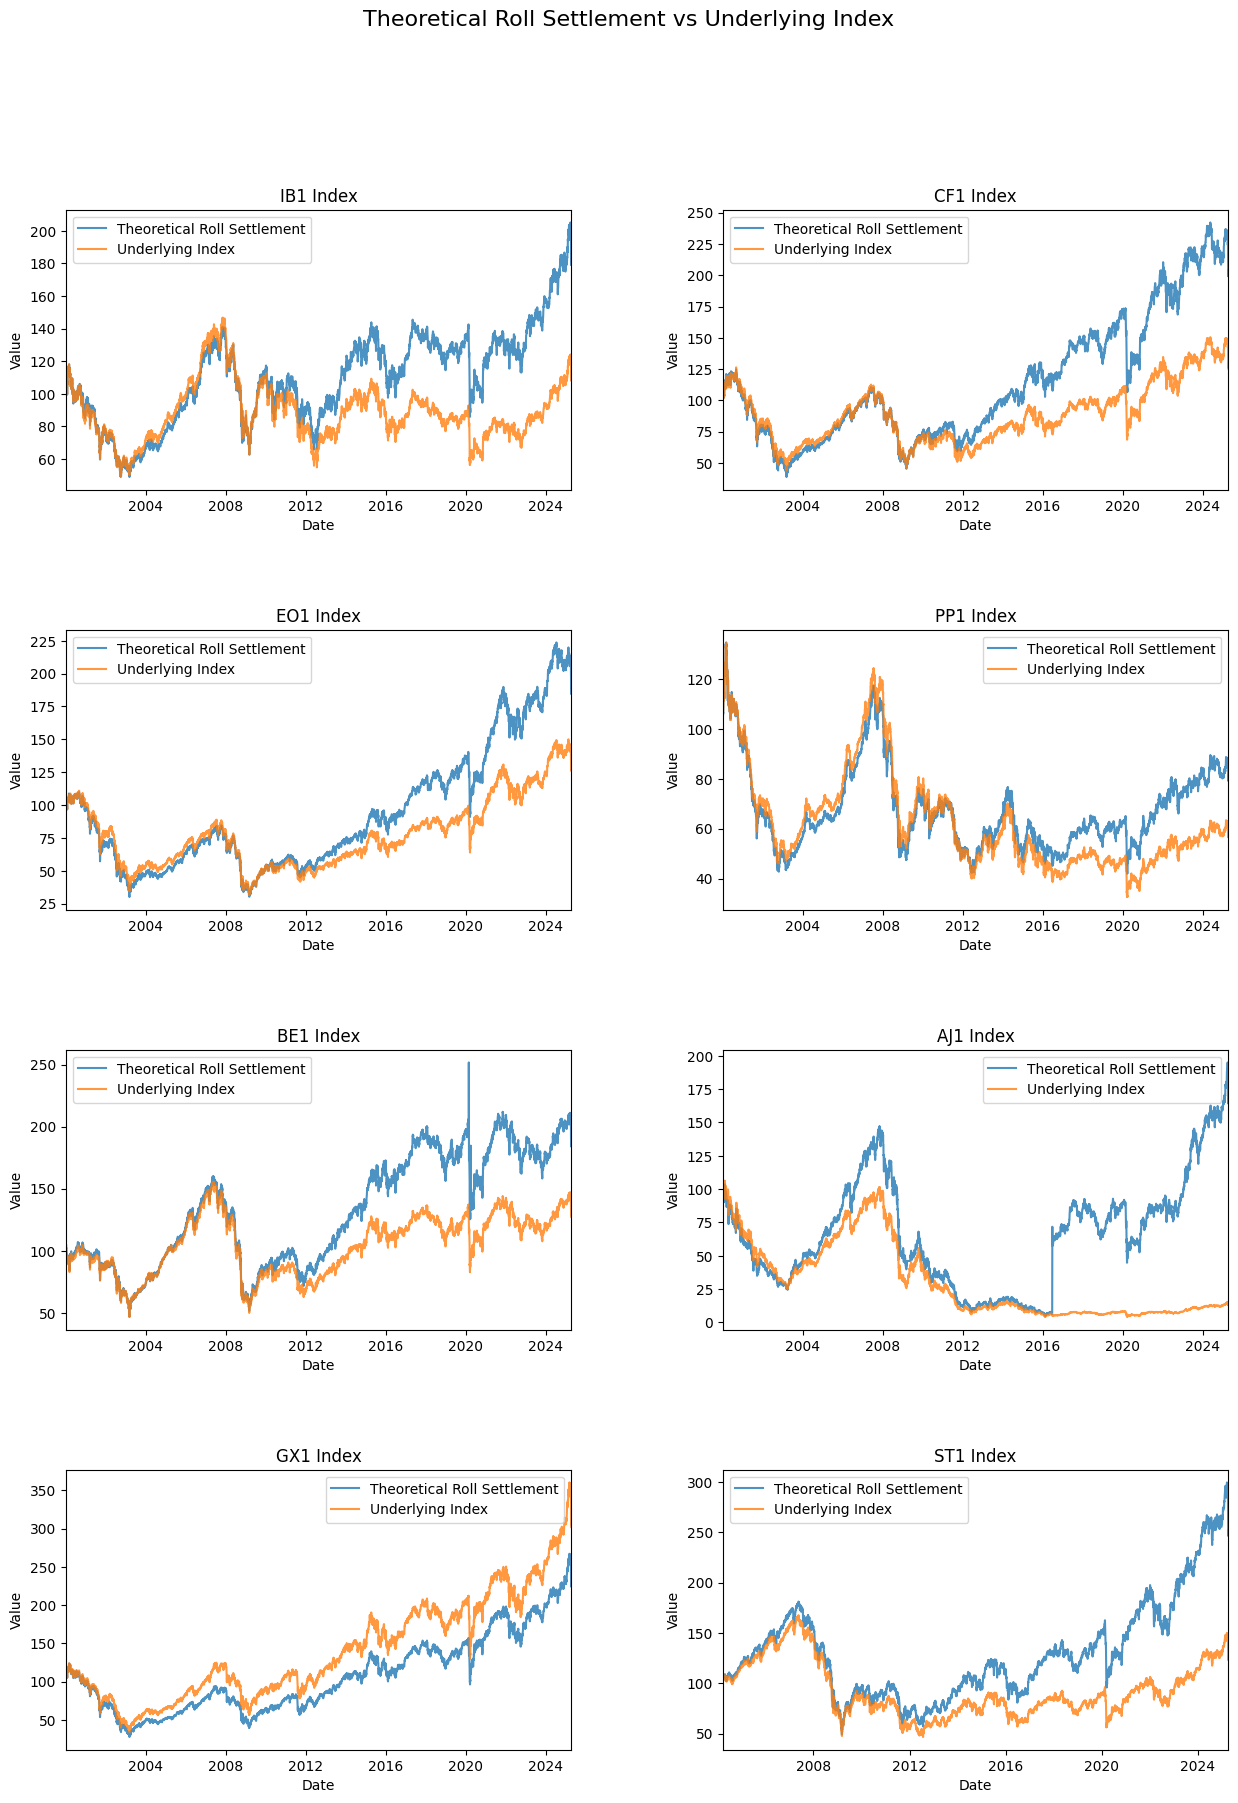

In [11]:
# Plotting the results of the theoretical roll
# VS the underlying index (fixing the start value to 100 for both)
# Each future has its own plot in a subplot
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Theoretical Roll Settlement vs Underlying Index', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for idx, future in enumerate(futures_euroindex):
    start_date = future.get_first_data_date()
    ax = axes[idx // 2, idx % 2]
    
    # Calculate multipliers to normalize both series to the same value at start_date
    roll_settle_start_value = future.roll_settle_theoretical.loc[start_date, 'Roll value']
    underlying_start_value = future.underlying_data.loc[start_date]
    
    roll_settle_multiplier = 100 / roll_settle_start_value
    underlying_multiplier = 100 / underlying_start_value
    
    # Plot normalized time series
    ax.plot(future.roll_settle_theoretical.index, 
            future.roll_settle_theoretical['Roll value'] * roll_settle_multiplier, 
            label='Theoretical Roll Settlement', alpha=0.8)
    ax.plot(future.underlying_data.index, 
            future.underlying_data * underlying_multiplier, 
            label='Underlying Index', alpha=0.8)
    
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

plt.show()

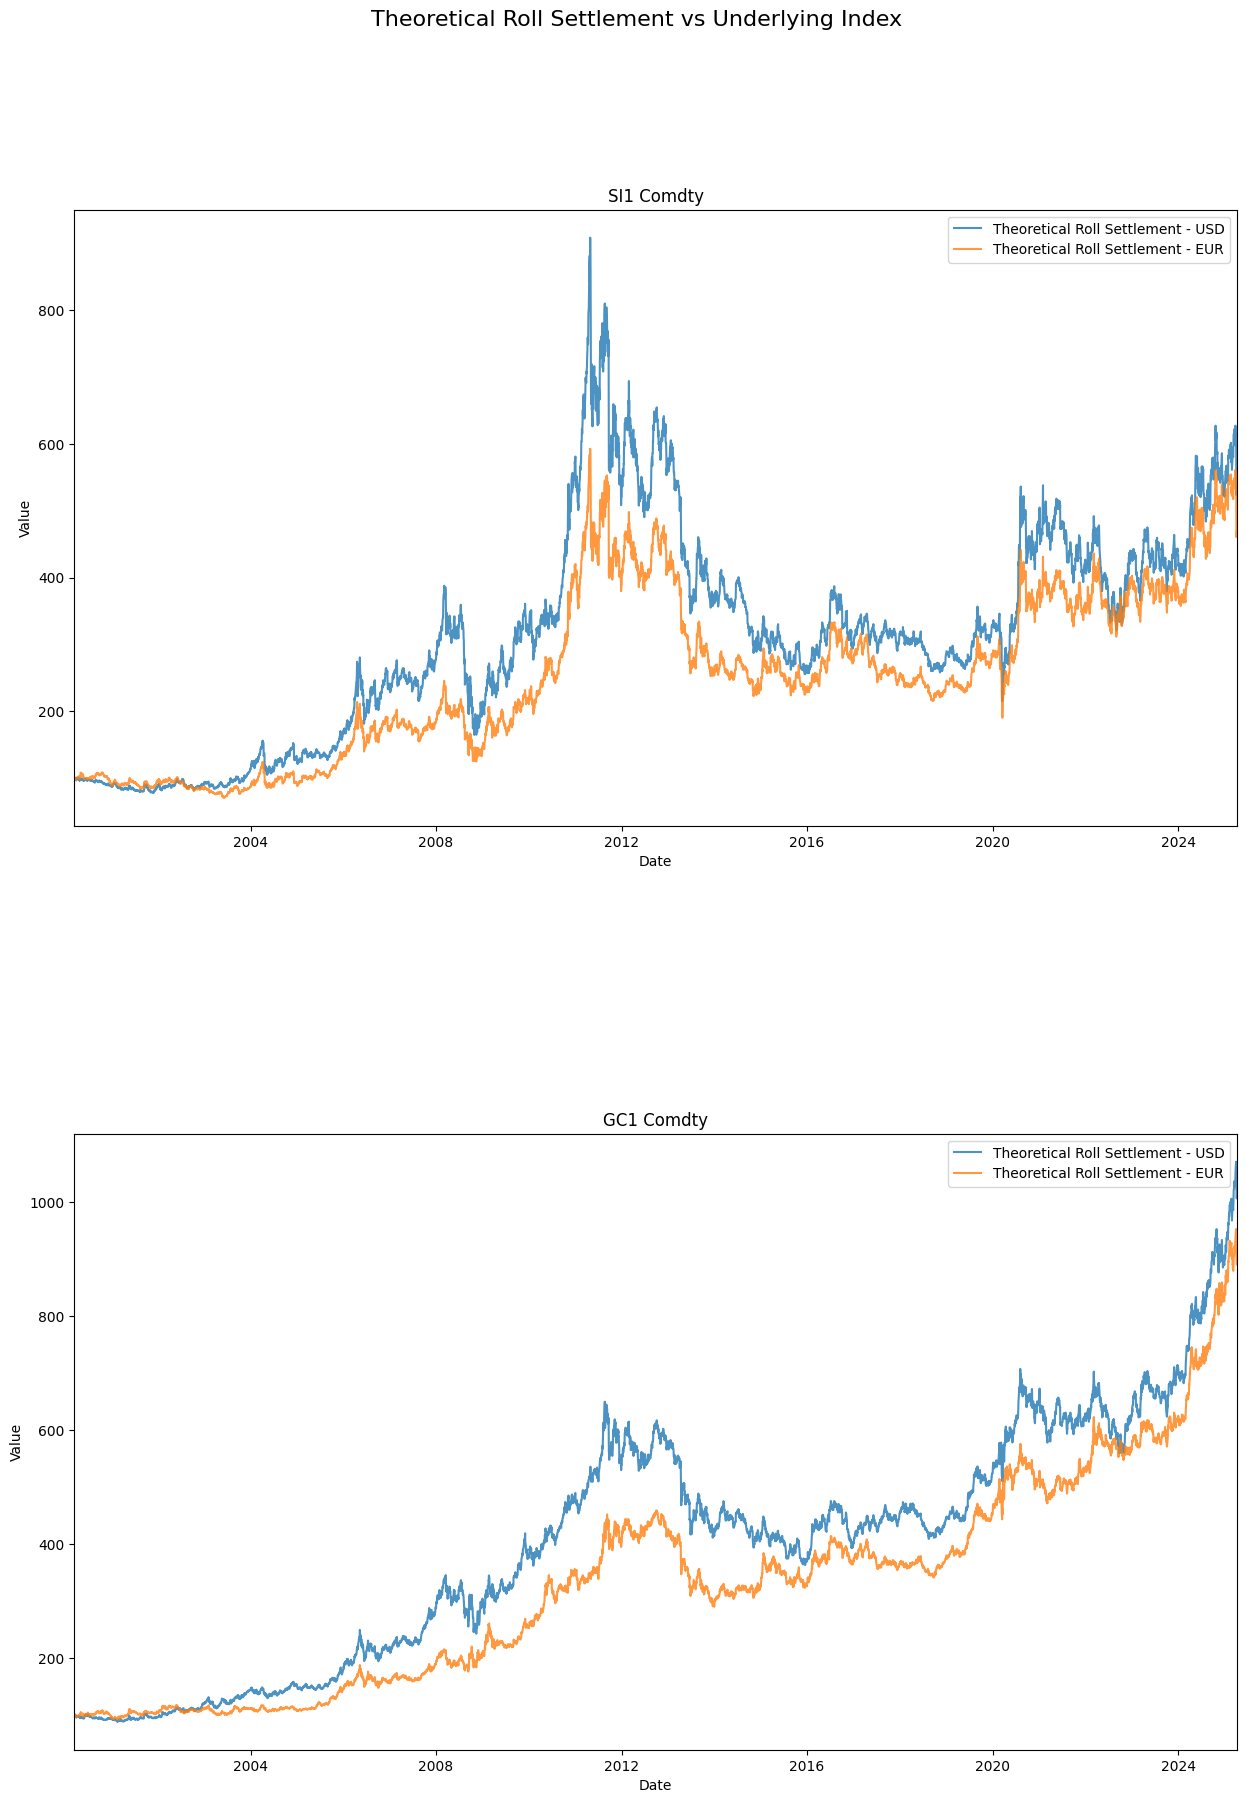

In [12]:
# Plotting the results of the theoretical roll
# For metals (there's not underlying prices)
# Here we will plot plot the value in USD and then the value in EUR in the same graph
fig, axes = plt.subplots(2, 1, figsize=(15, 20))
fig.suptitle('Theoretical Roll Settlement vs Underlying Index', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, future in enumerate(futures_metals):
    start_date = future.get_first_data_date()
    ax = axes[idx]
    
    # Calculate multipliers to normalize both series to the same value at start_date
    roll_settle_start_value = future.roll_settle_theoretical.loc[start_date, 'Roll value']
    roll_settle_multiplier = 100 / roll_settle_start_value
    
    # Plot normalized time series
    ax.plot(future.roll_settle_theoretical.index, 
            future.roll_settle_theoretical['Roll value'] * roll_settle_multiplier, 
            label='Theoretical Roll Settlement - USD', alpha=0.8)
    
    # Now getting the value in EUR
    roll_settle_start_value_eur = future.roll_settle_theoretical.loc[start_date, 'Roll value'] * future.currency_object.px_bid.loc[start_date]
    roll_settle_multiplier_eur = 100 / roll_settle_start_value_eur

    # Align px_bid to the roll_settle_theoretical index
    px_bid_aligned = future.currency_object.px_bid.reindex(future.roll_settle_theoretical.index)

    ax.plot(future.roll_settle_theoretical.index, 
            future.roll_settle_theoretical['Roll value'] * roll_settle_multiplier_eur * px_bid_aligned, 
            label='Theoretical Roll Settlement - EUR', alpha=0.8)
    
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

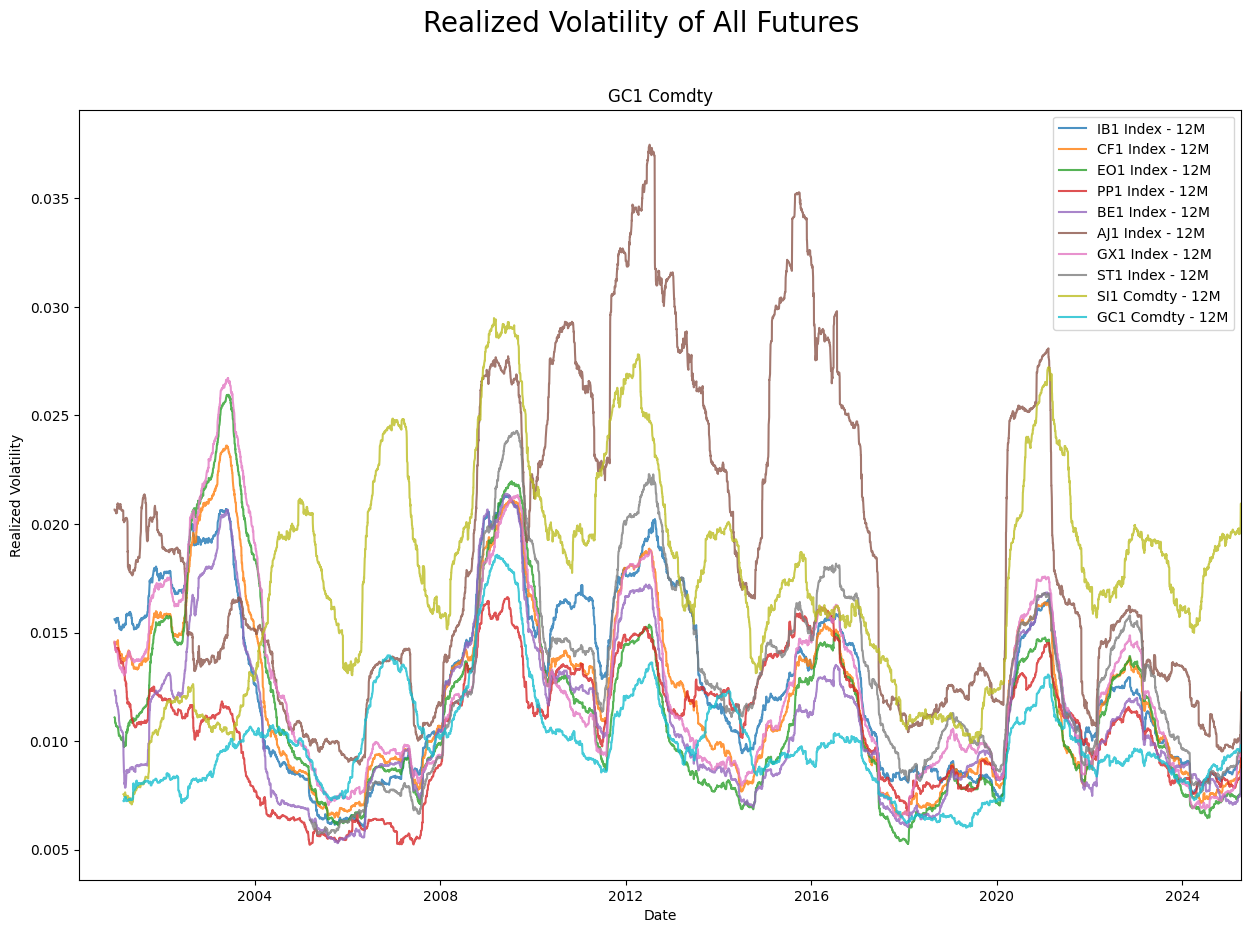

In [13]:
# Plotting all the futures realized volatilities for the roll settlement
# 12M all in one plot to compare
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle('Realized Volatility of All Futures', fontsize=20)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, future in enumerate(futures_euroindex):
    ax.plot(future.realized_vol_roll_12MROLL.index,
            future.realized_vol_roll_12MROLL.values,
            label=f'{future.name} - 12M',
            alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()
for idx, future in enumerate(futures_metals):
    ax.plot(future.realized_vol_roll_12MROLL.index,
            future.realized_vol_roll_12MROLL.values,
            label=f'{future.name} - 12M',
            alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()
plt.show()

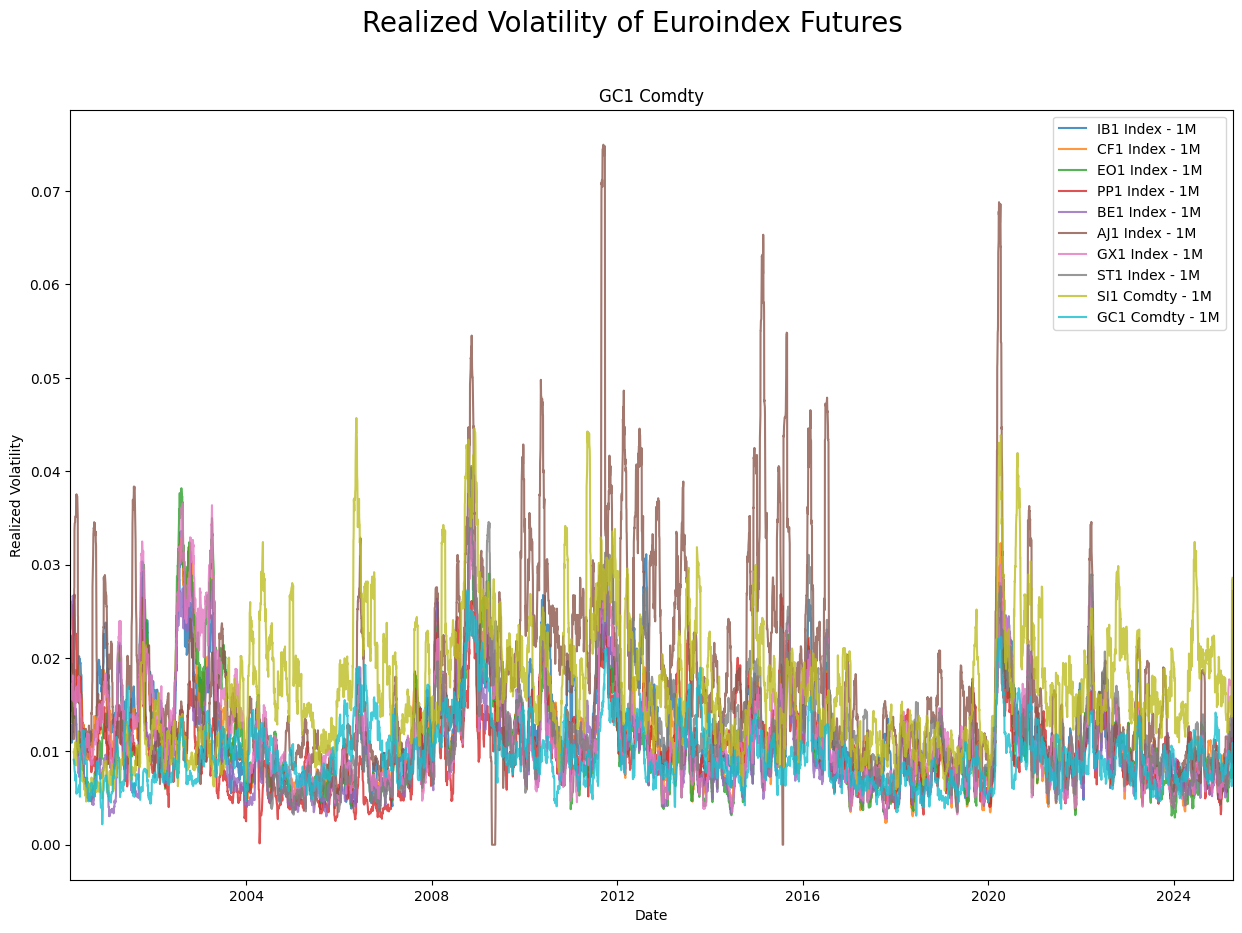

In [14]:
# Plotting all the futures realized volatilities for the roll settlement
# 1M all in one plot to compare
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle('Realized Volatility of Euroindex Futures', fontsize=20)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, future in enumerate(futures_euroindex):
    ax.plot(future.realized_vol_roll_1MROLL.index,
            future.realized_vol_roll_1MROLL.values,
            label=f'{future.name} - 1M',
            alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()
for idx, future in enumerate(futures_metals):
    ax.plot(future.realized_vol_roll_1MROLL.index,
            future.realized_vol_roll_1MROLL.values,
            label=f'{future.name} - 1M',
            alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()
plt.show()

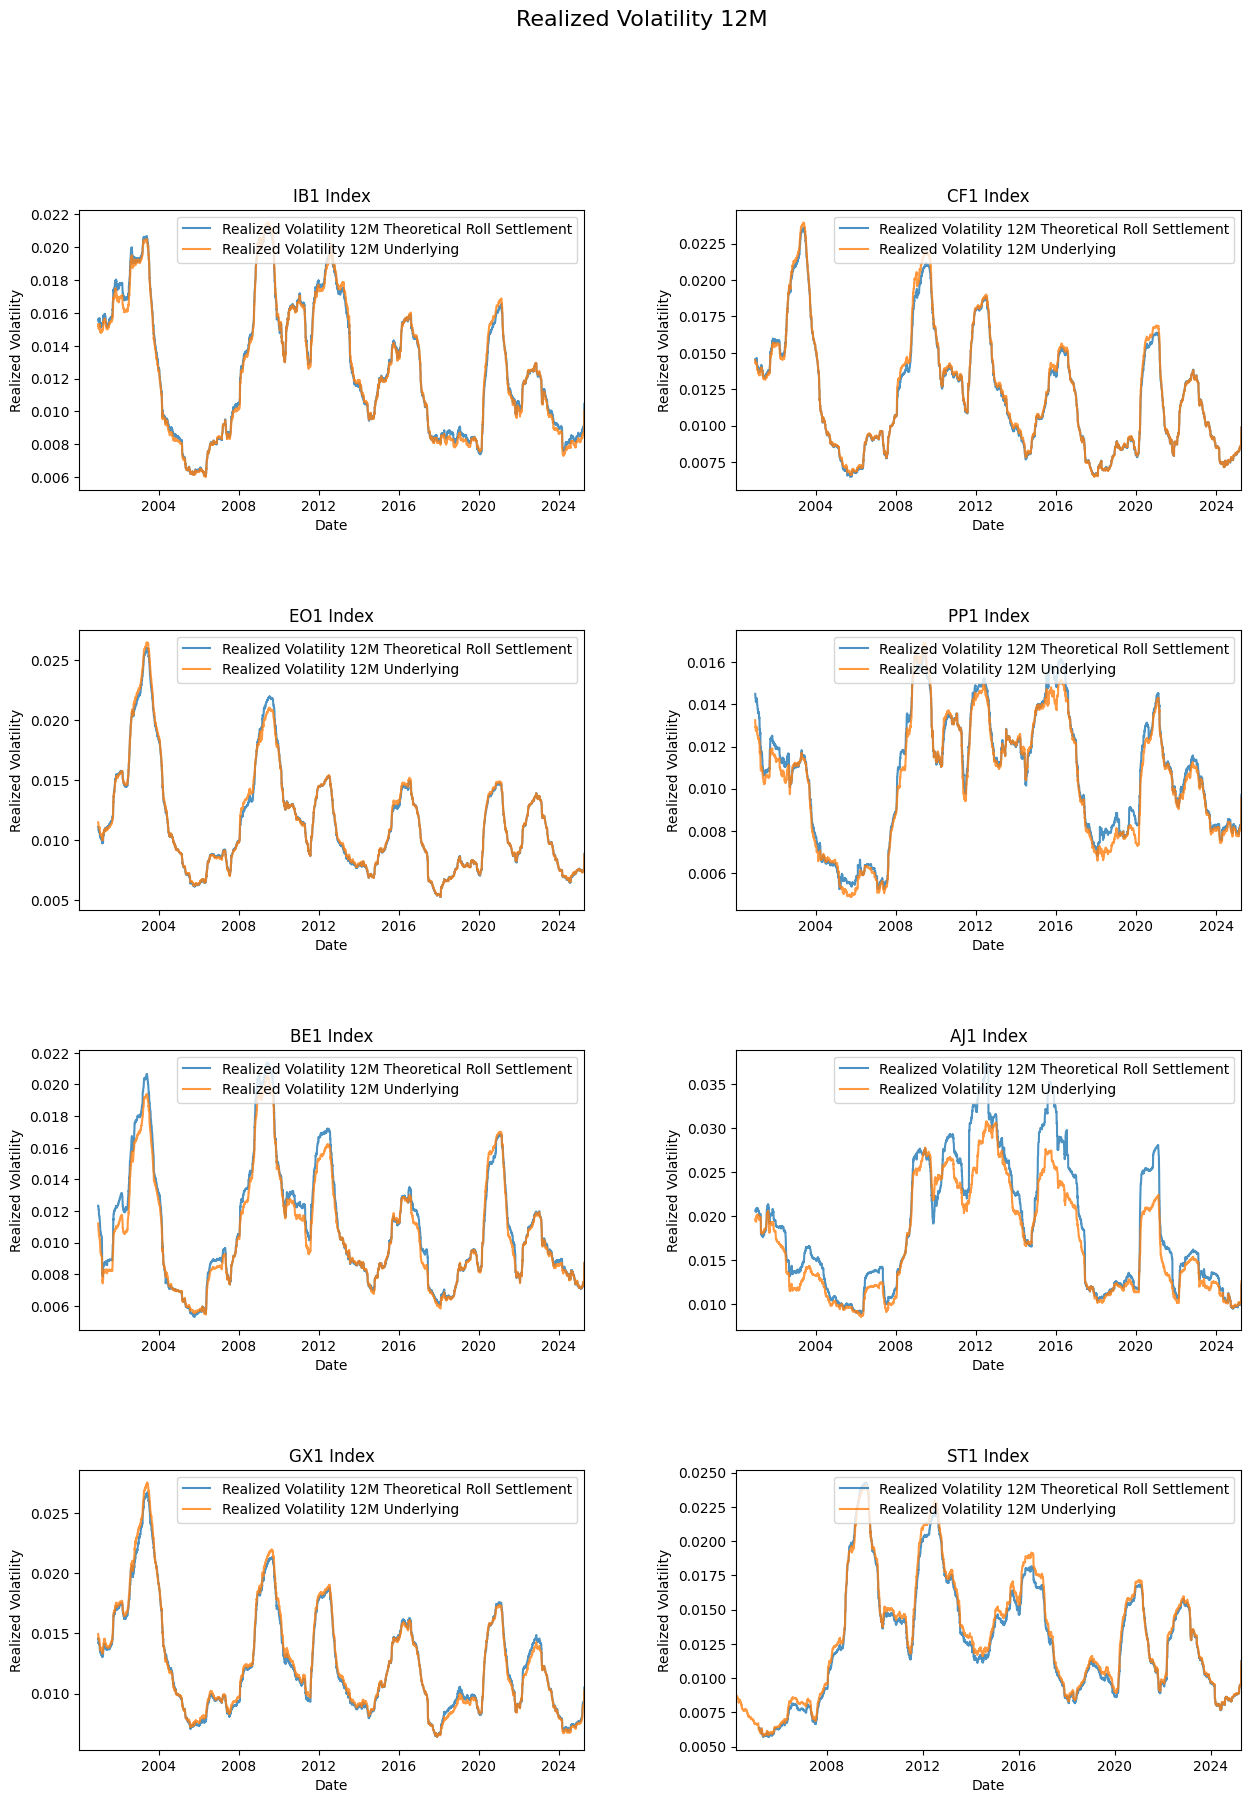

In [15]:
# Plotting the realized volatility of the theoretical roll
# With also the realized volatility of the underlying
# Here, 12M
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Realized Volatility 12M', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (i, future) in enumerate(enumerate(futures_euroindex)):
    ax = axes[idx // 2, idx % 2]
    
    ax.plot(future.realized_vol_roll_12MROLL.index,
            future.realized_vol_roll_12MROLL, 
            label='Realized Volatility 12M Theoretical Roll Settlement', alpha=0.8)
    ax.plot(future.realized_vol_undr_12MROLL.index,
            future.realized_vol_undr_12MROLL, 
            label='Realized Volatility 12M Underlying', alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()
plt.show()

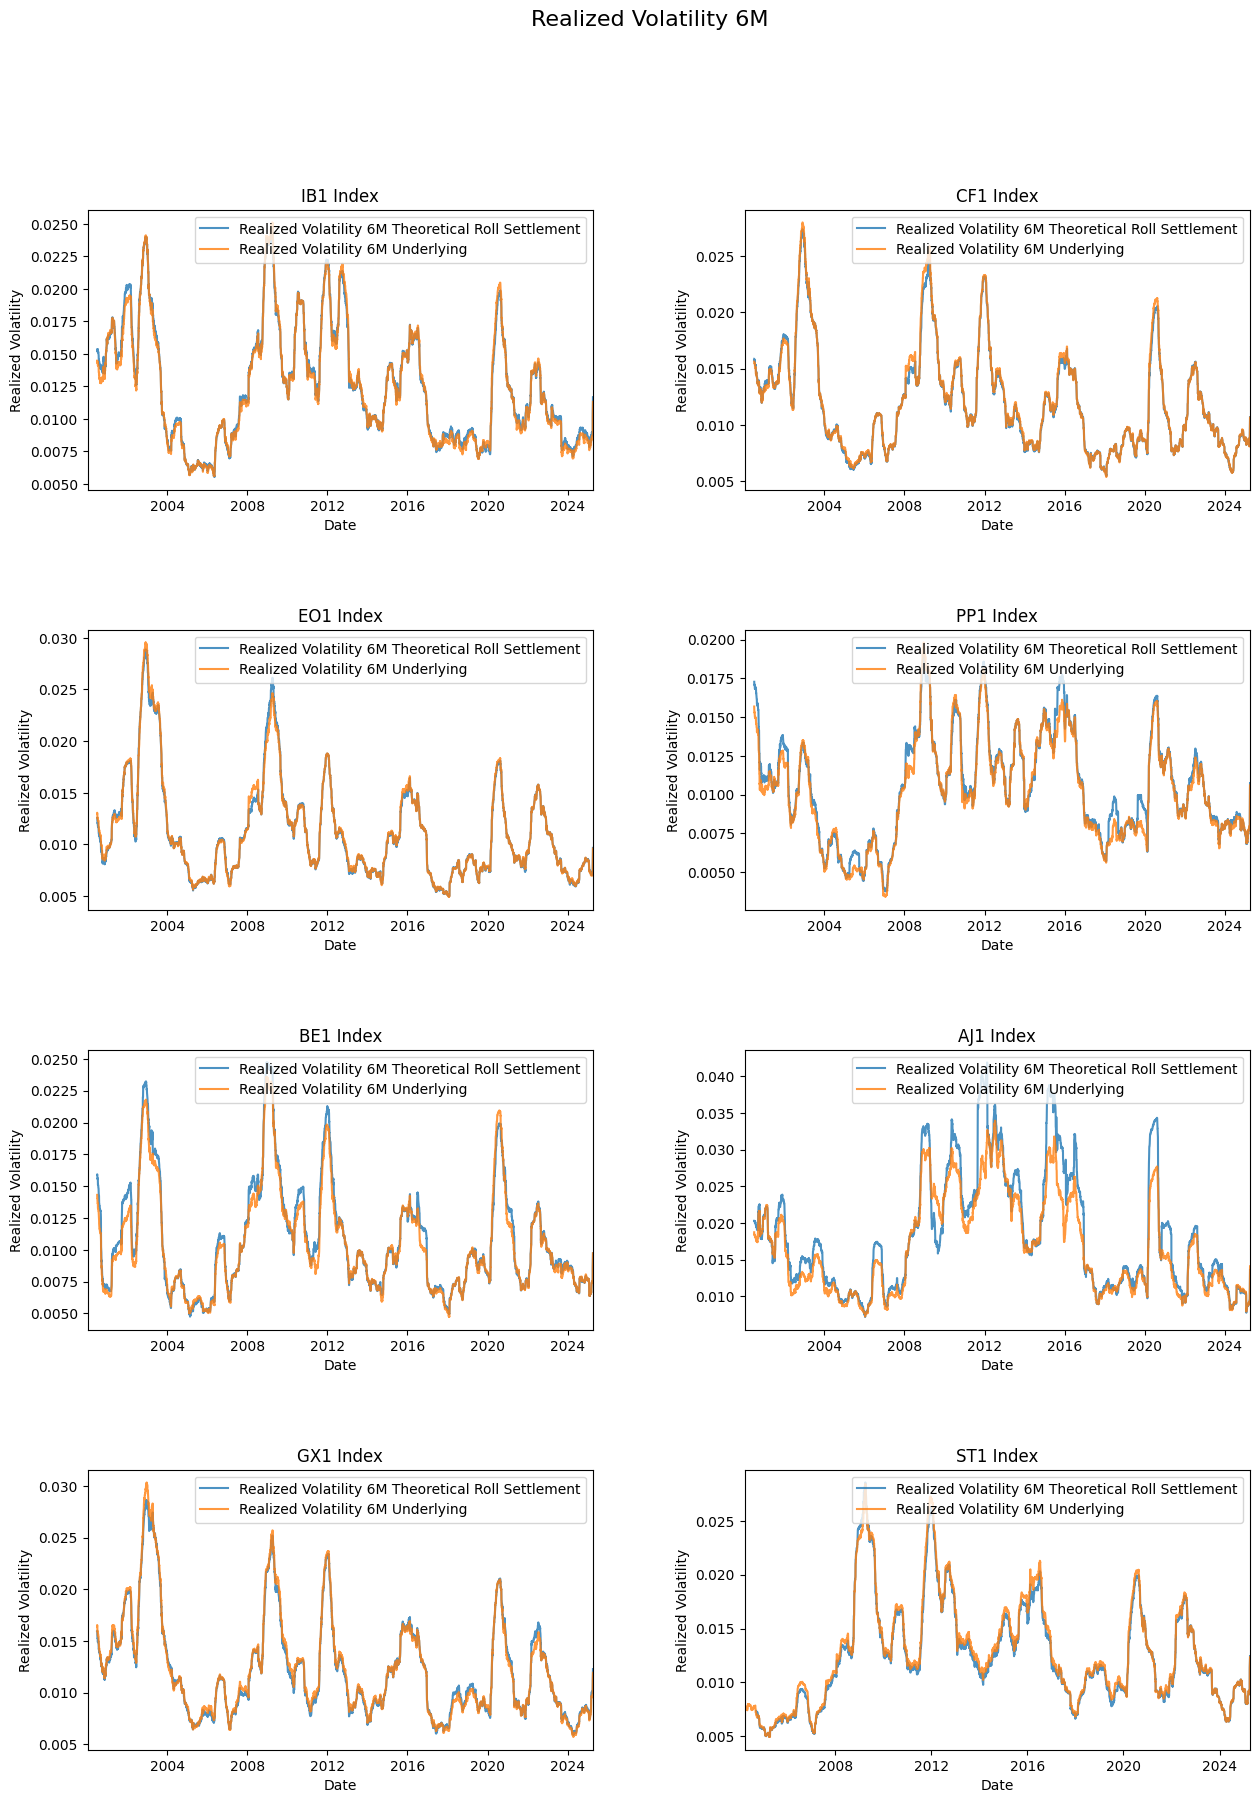

In [16]:
# Plotting the realized volatility of the theoretical roll
# With also the realized volatility of the underlying
# Here, 6M
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Realized Volatility 6M', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (i, future) in enumerate(enumerate(futures_euroindex)):
    ax = axes[idx // 2, idx % 2]
    
    ax.plot(future.realized_vol_roll_6MROLL.index,
            future.realized_vol_roll_6MROLL, 
            label='Realized Volatility 6M Theoretical Roll Settlement', alpha=0.8)
    ax.plot(future.realized_vol_undr_6MROLL.index,
            future.realized_vol_undr_6MROLL, 
            label='Realized Volatility 6M Underlying', alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()
plt.show()

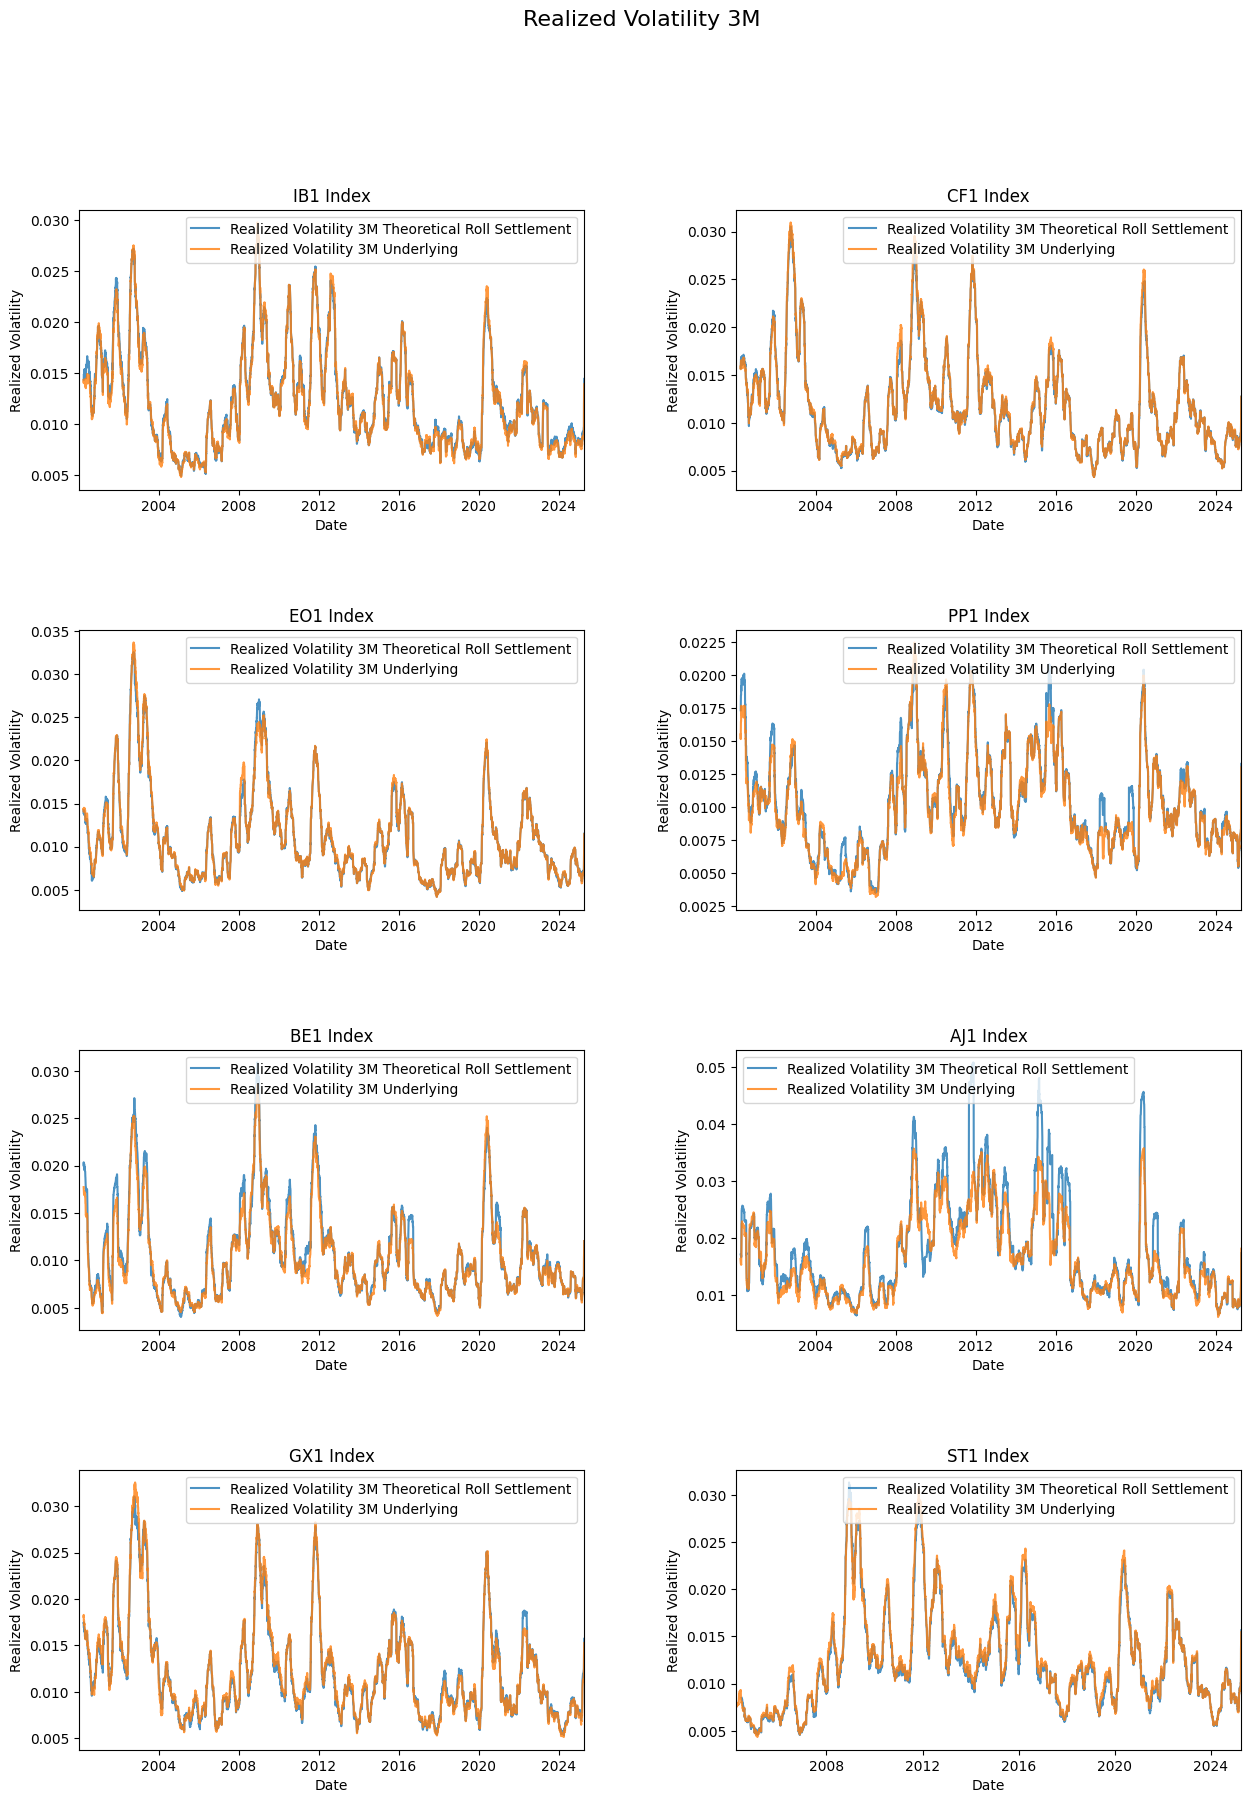

In [17]:
# Plotting the realized volatility of the theoretical roll
# With also the realized volatility of the underlying
# Here, 3M
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Realized Volatility 3M', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (i, future) in enumerate(enumerate(futures_euroindex)):
    ax = axes[idx // 2, idx % 2]
    
    ax.plot(future.realized_vol_roll_3MROLL.index,
            future.realized_vol_roll_3MROLL, 
            label='Realized Volatility 3M Theoretical Roll Settlement', alpha=0.8)
    ax.plot(future.realized_vol_undr_3MROLL.index,
            future.realized_vol_undr_3MROLL, 
            label='Realized Volatility 3M Underlying', alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()
plt.show()

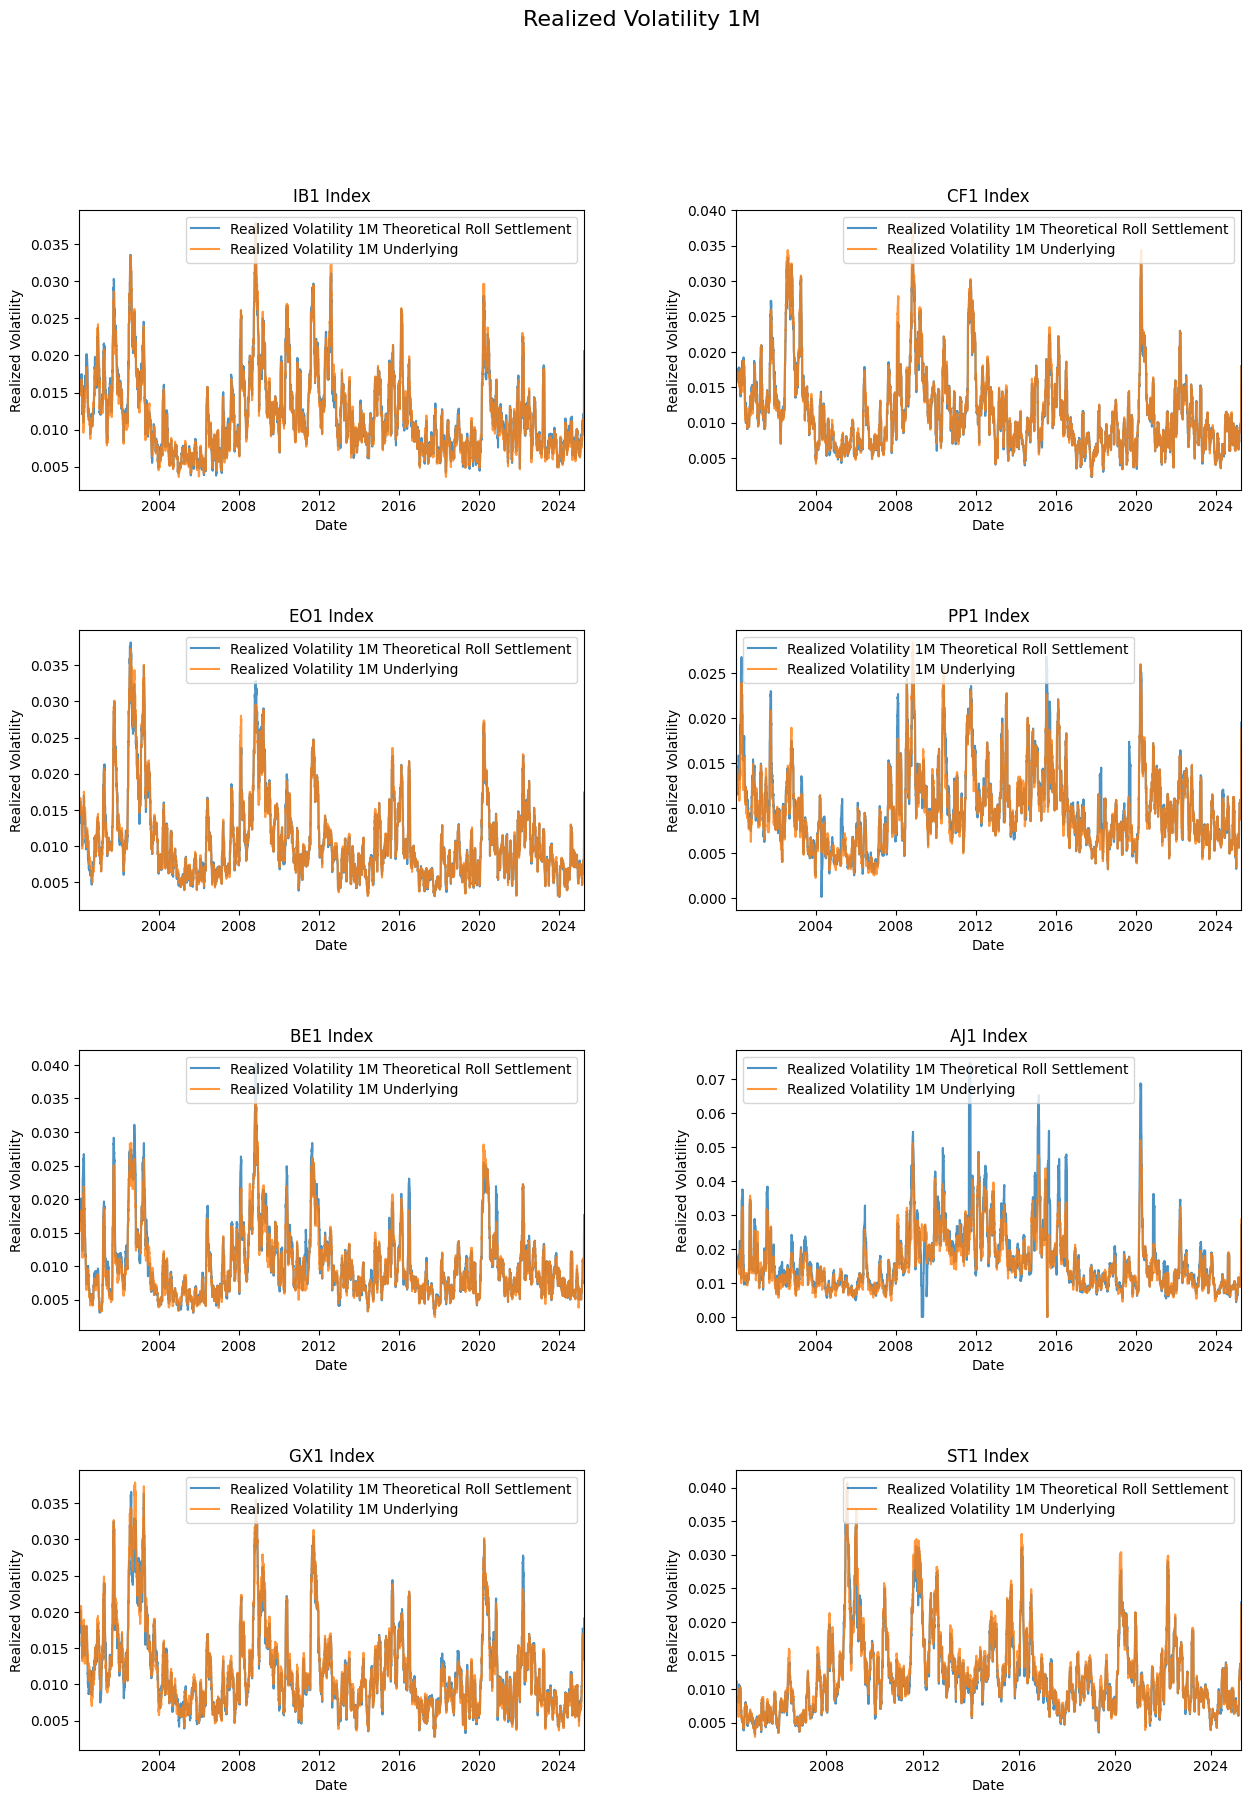

In [18]:
# Plotting the realized volatility of the theoretical roll
# With also the realized volatility of the underlying
# Here, 1M
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Realized Volatility 1M', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (i, future) in enumerate(enumerate(futures_euroindex)):
    ax = axes[idx // 2, idx % 2]
    
    ax.plot(future.realized_vol_roll_1MROLL.index,
            future.realized_vol_roll_1MROLL, 
            label='Realized Volatility 1M Theoretical Roll Settlement', alpha=0.8)
    ax.plot(future.realized_vol_undr_1MROLL.index,
            future.realized_vol_undr_1MROLL, 
            label='Realized Volatility 1M Underlying', alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()
plt.show()

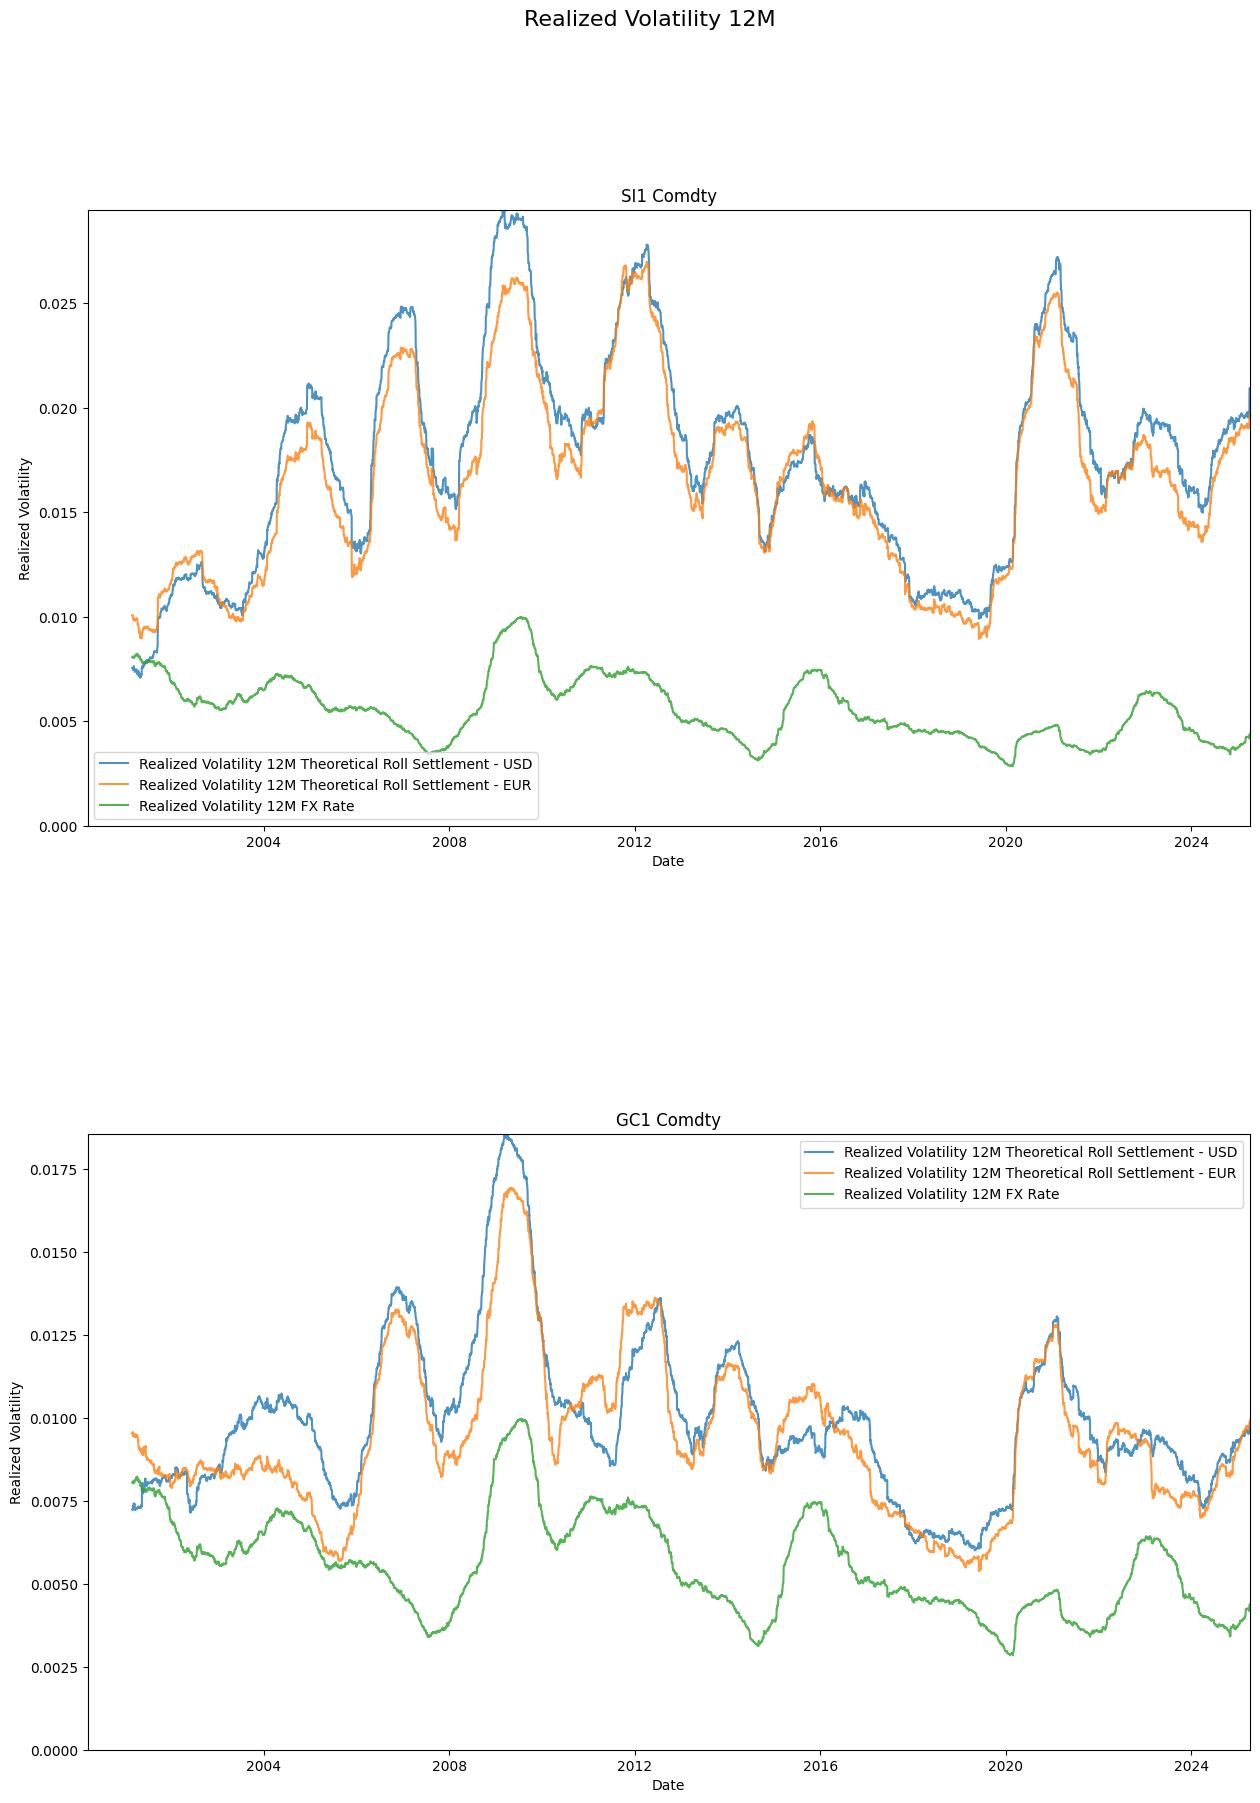

In [19]:
# For metal futures:
# Plotting the realized volatility of the theoretical roll in USD
# With also the realized volatility of the theoretical roll in EUR
# With also the realized volatility of the FX rate
# Here, 12M
fig, axes = plt.subplots(2, 1, figsize=(15, 20))
fig.suptitle('Realized Volatility 12M', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (i, future) in enumerate(enumerate(futures_metals)):
    ax = axes[idx]
    ax.plot(future.realized_vol_roll_1MROLL.index,
            future.realized_vol_roll_12MROLL, 
            label='Realized Volatility 12M Theoretical Roll Settlement - USD', alpha=0.8)
    ax.plot(future.realized_vol_price_base_currency_12MROLL.index,
            future.realized_vol_price_base_currency_12MROLL,
            label='Realized Volatility 12M Theoretical Roll Settlement - EUR', alpha=0.8)
    ax.plot(future.realized_vol_currency_12MROLL.index,
            future.realized_vol_currency_12MROLL, 
            label='Realized Volatility 12M FX Rate', alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_ylim([0, max(future.realized_vol_roll_12MROLL.max(), future.realized_vol_price_base_currency_12MROLL.max(), future.realized_vol_currency_12MROLL.max())])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()
plt.show()


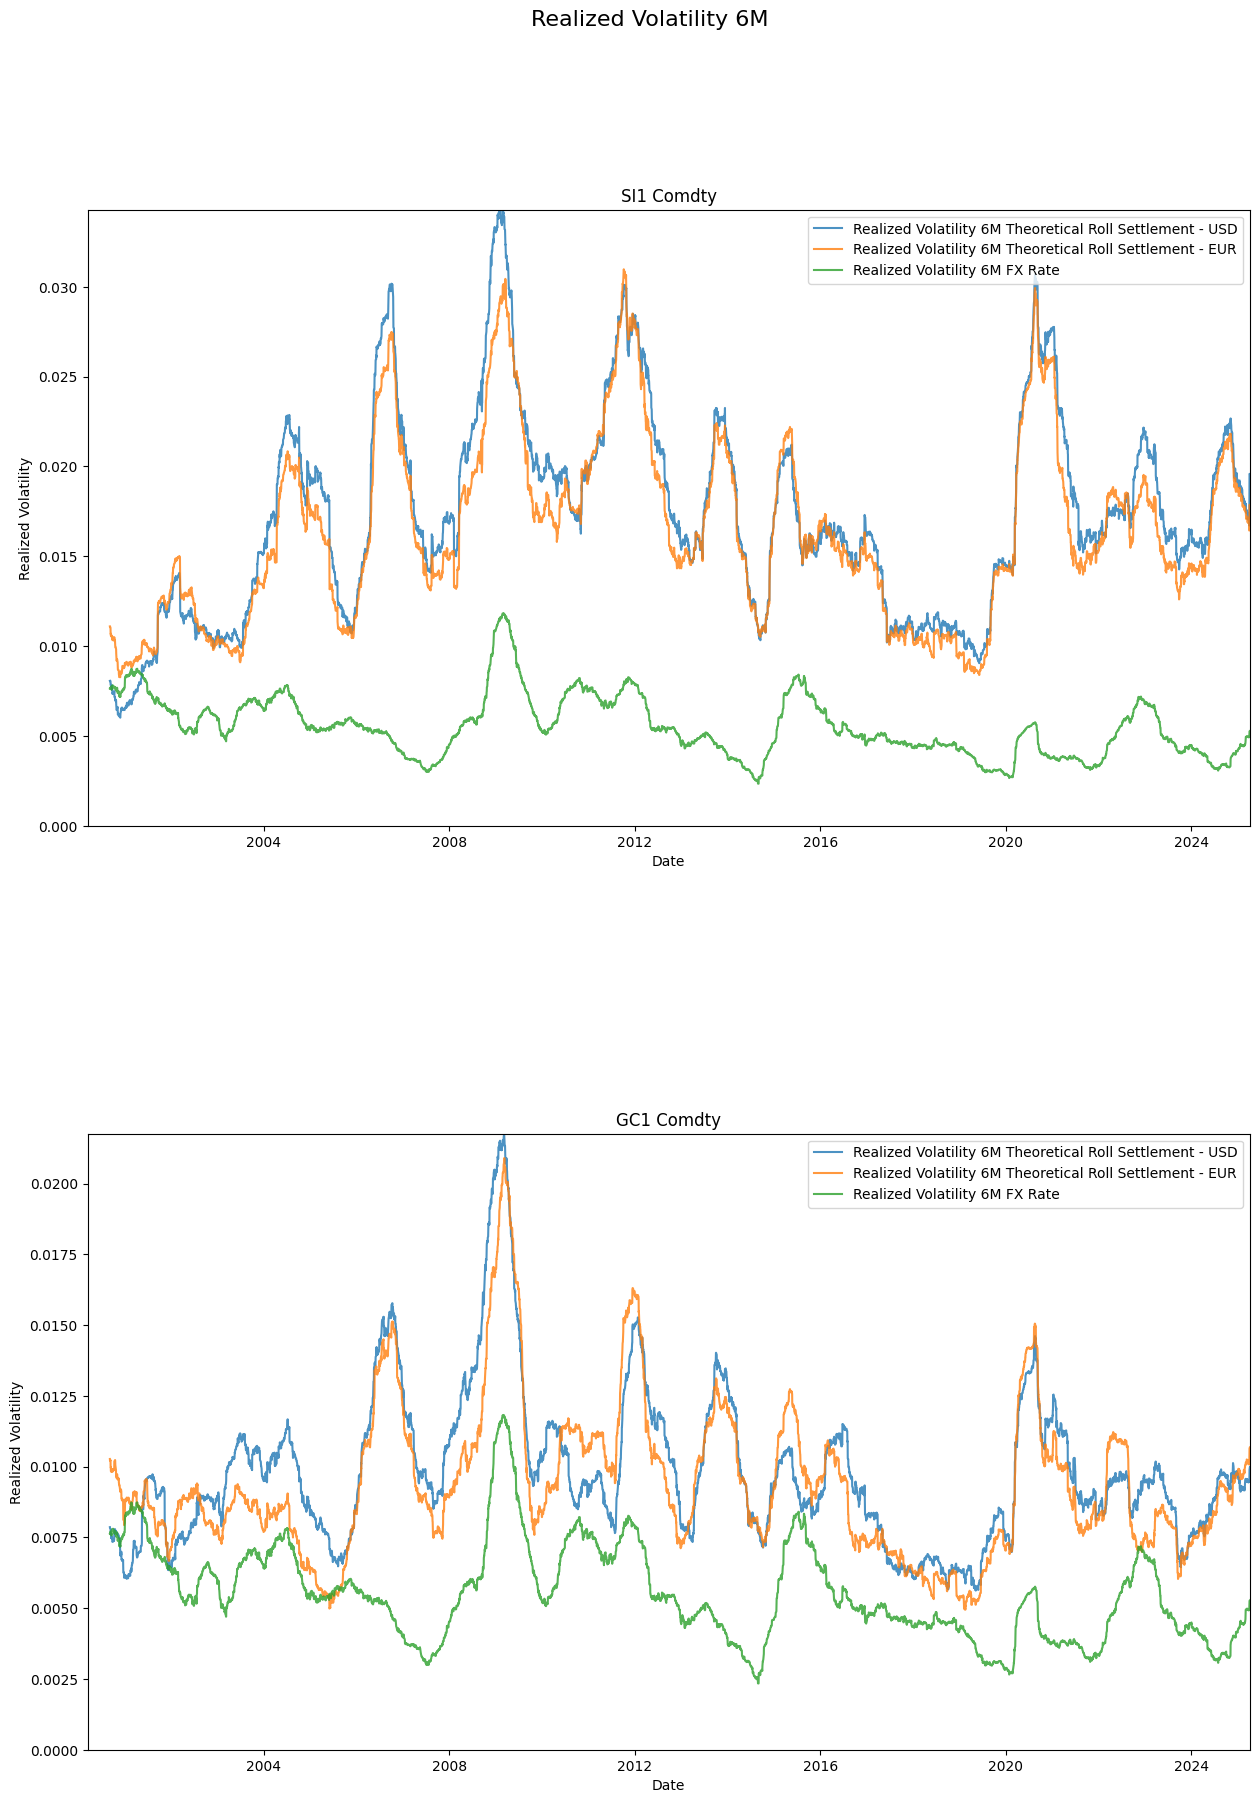

In [20]:
# For metal futures:
# Plotting the realized volatility of the theoretical roll in USD
# With also the realized volatility of the theoretical roll in EUR
# With also the realized volatility of the FX rate
# Here, 6M
fig, axes = plt.subplots(2, 1, figsize=(15, 20))
fig.suptitle('Realized Volatility 6M', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (i, future) in enumerate(enumerate(futures_metals)):
    ax = axes[idx]
    ax.plot(future.realized_vol_roll_1MROLL.index,
            future.realized_vol_roll_6MROLL, 
            label='Realized Volatility 6M Theoretical Roll Settlement - USD', alpha=0.8)
    ax.plot(future.realized_vol_price_base_currency_6MROLL.index,
            future.realized_vol_price_base_currency_6MROLL,
            label='Realized Volatility 6M Theoretical Roll Settlement - EUR', alpha=0.8)
    ax.plot(future.realized_vol_currency_6MROLL.index,
            future.realized_vol_currency_6MROLL, 
            label='Realized Volatility 6M FX Rate', alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_ylim([0, max(future.realized_vol_roll_6MROLL.max(), future.realized_vol_price_base_currency_6MROLL.max(), future.realized_vol_currency_6MROLL.max())])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()

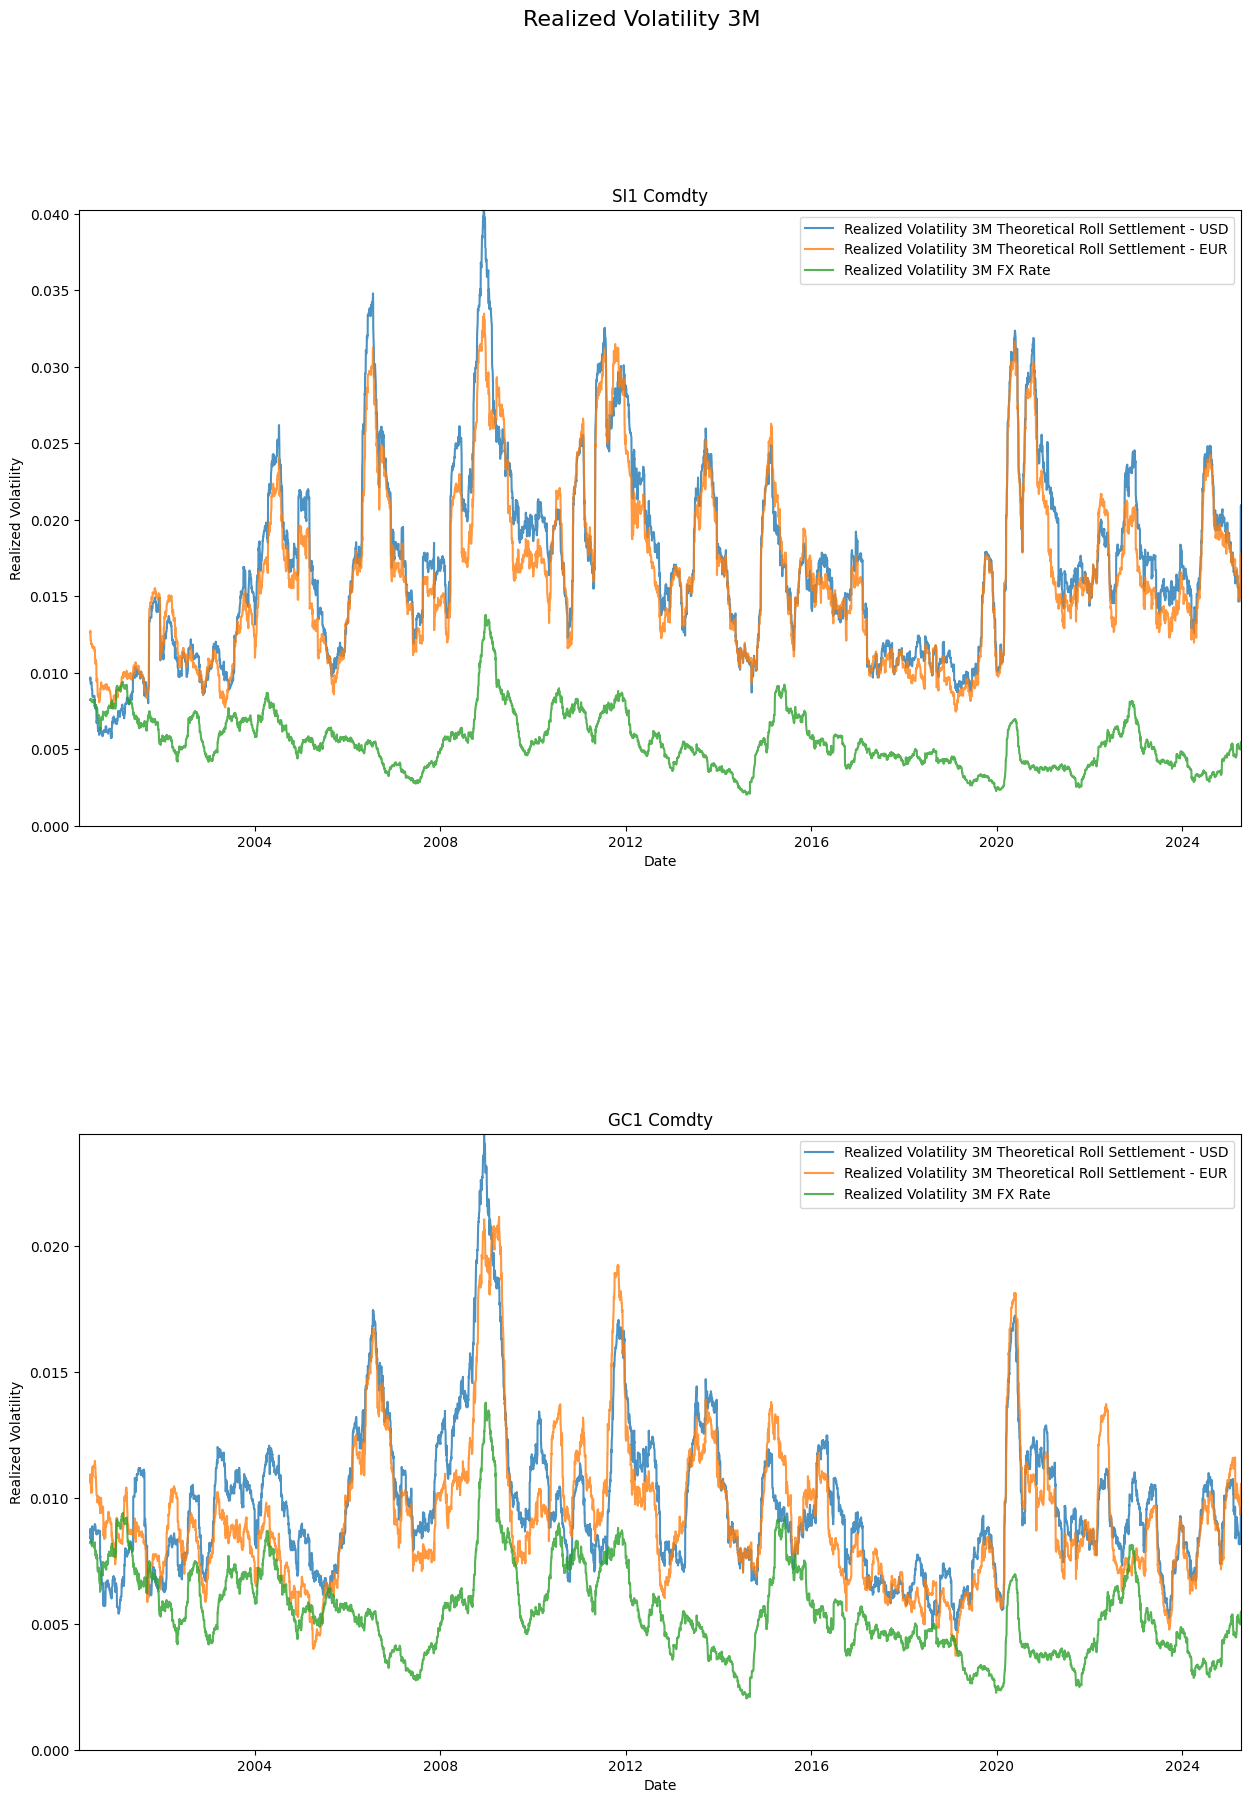

In [21]:
# For metal futures:
# Plotting the realized volatility of the theoretical roll in USD
# With also the realized volatility of the theoretical roll in EUR
# With also the realized volatility of the FX rate
# Here, 3M
fig, axes = plt.subplots(2, 1, figsize=(15, 20))
fig.suptitle('Realized Volatility 3M', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (i, future) in enumerate(enumerate(futures_metals)):
    ax = axes[idx]
    ax.plot(future.realized_vol_roll_1MROLL.index,
            future.realized_vol_roll_3MROLL, 
            label='Realized Volatility 3M Theoretical Roll Settlement - USD', alpha=0.8)
    ax.plot(future.realized_vol_price_base_currency_3MROLL.index,
            future.realized_vol_price_base_currency_3MROLL,
            label='Realized Volatility 3M Theoretical Roll Settlement - EUR', alpha=0.8)
    ax.plot(future.realized_vol_currency_3MROLL.index,
            future.realized_vol_currency_3MROLL, 
            label='Realized Volatility 3M FX Rate', alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_ylim([0, max(future.realized_vol_roll_3MROLL.max(), future.realized_vol_price_base_currency_3MROLL.max(), future.realized_vol_currency_3MROLL.max())])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()

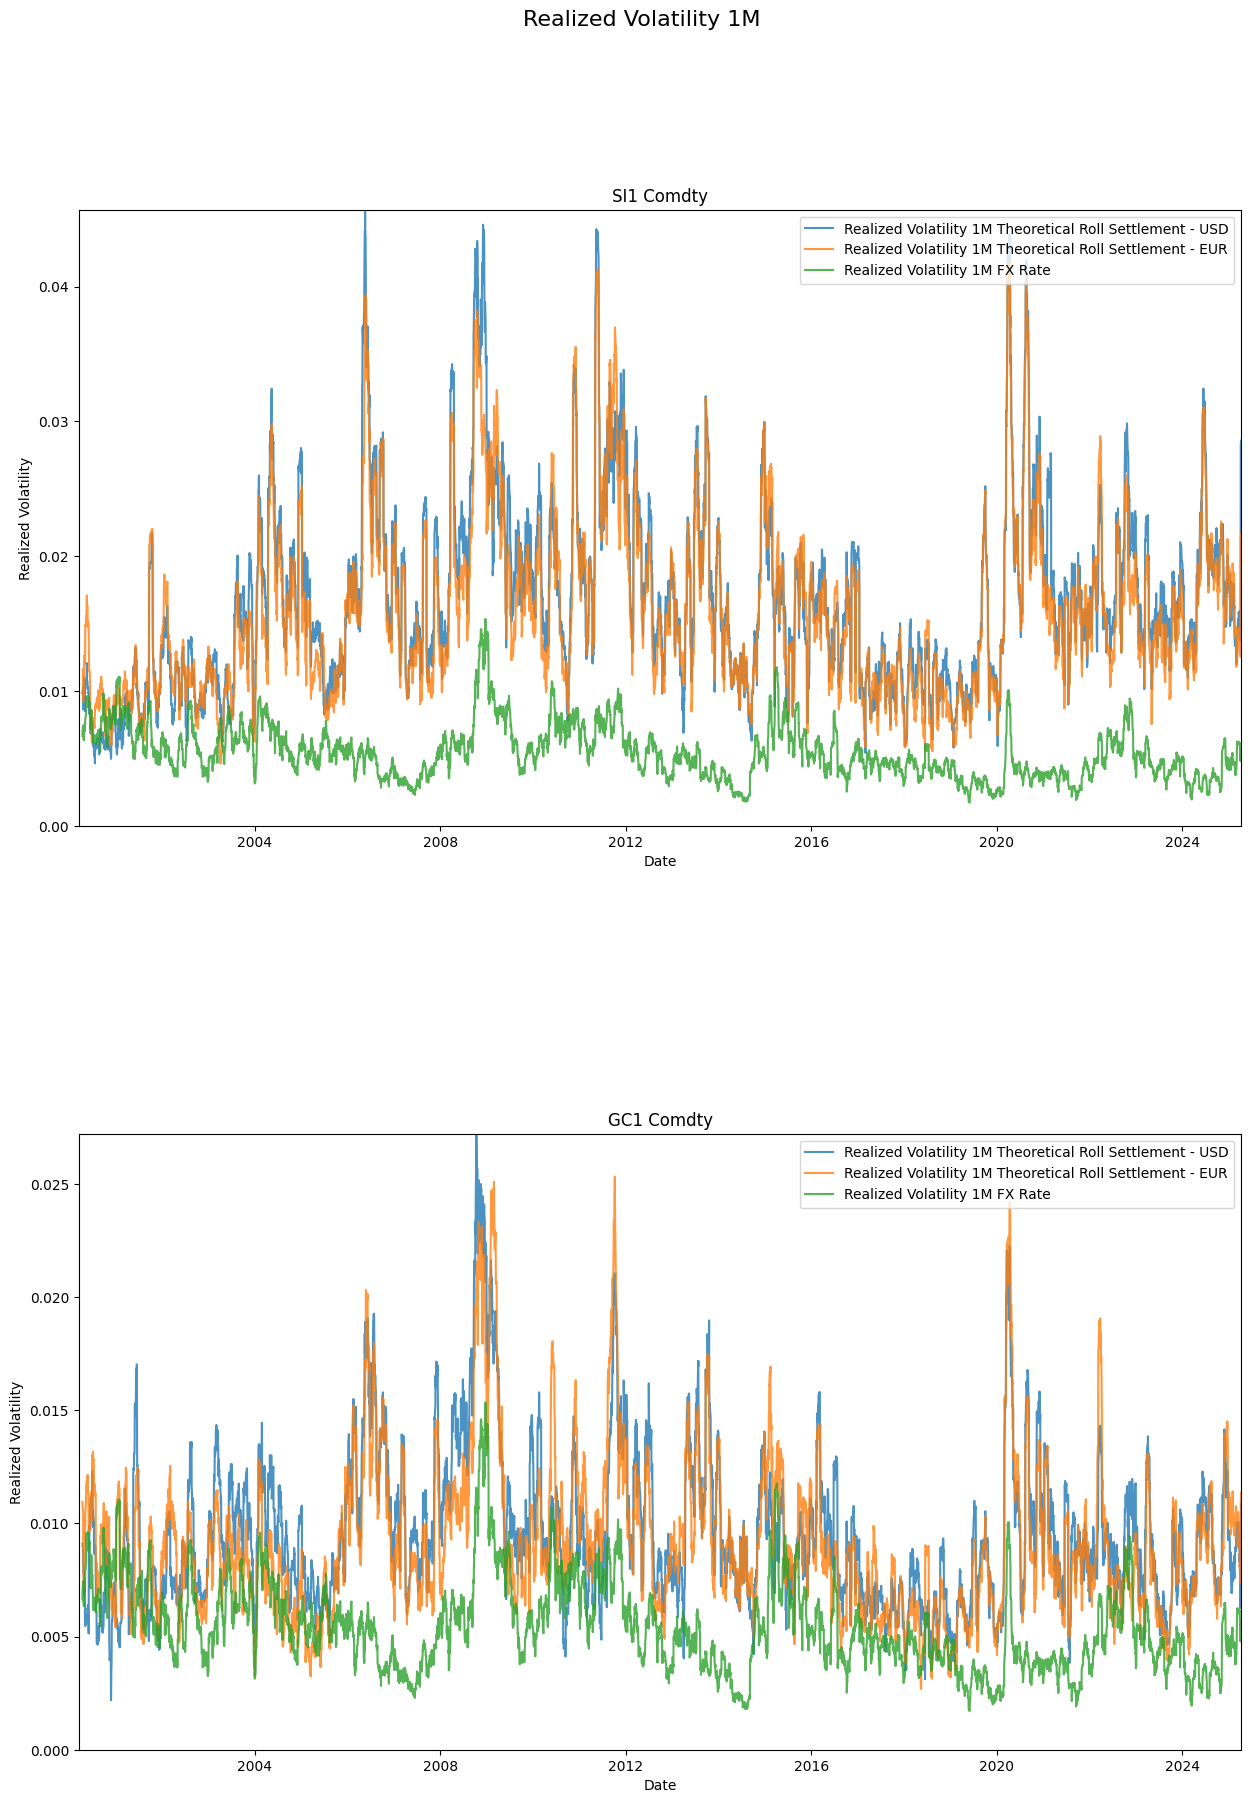

In [22]:
# For metal futures:
# Plotting the realized volatility of the theoretical roll in USD
# With also the realized volatility of the theoretical roll in EUR
# With also the realized volatility of the FX rate
# Here, 1M
fig, axes = plt.subplots(2, 1, figsize=(15, 20))
fig.suptitle('Realized Volatility 1M', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (i, future) in enumerate(enumerate(futures_metals)):
    ax = axes[idx]
    ax.plot(future.realized_vol_roll_1MROLL.index,
            future.realized_vol_roll_1MROLL, 
            label='Realized Volatility 1M Theoretical Roll Settlement - USD', alpha=0.8)
    ax.plot(future.realized_vol_price_base_currency_1MROLL.index,
            future.realized_vol_price_base_currency_1MROLL,
            label='Realized Volatility 1M Theoretical Roll Settlement - EUR', alpha=0.8)
    ax.plot(future.realized_vol_currency_1MROLL.index,
            future.realized_vol_currency_1MROLL, 
            label='Realized Volatility 1M FX Rate', alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_ylim([0, max(future.realized_vol_roll_1MROLL.max(), future.realized_vol_price_base_currency_1MROLL.max(), future.realized_vol_currency_1MROLL.max())])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()
plt.show()

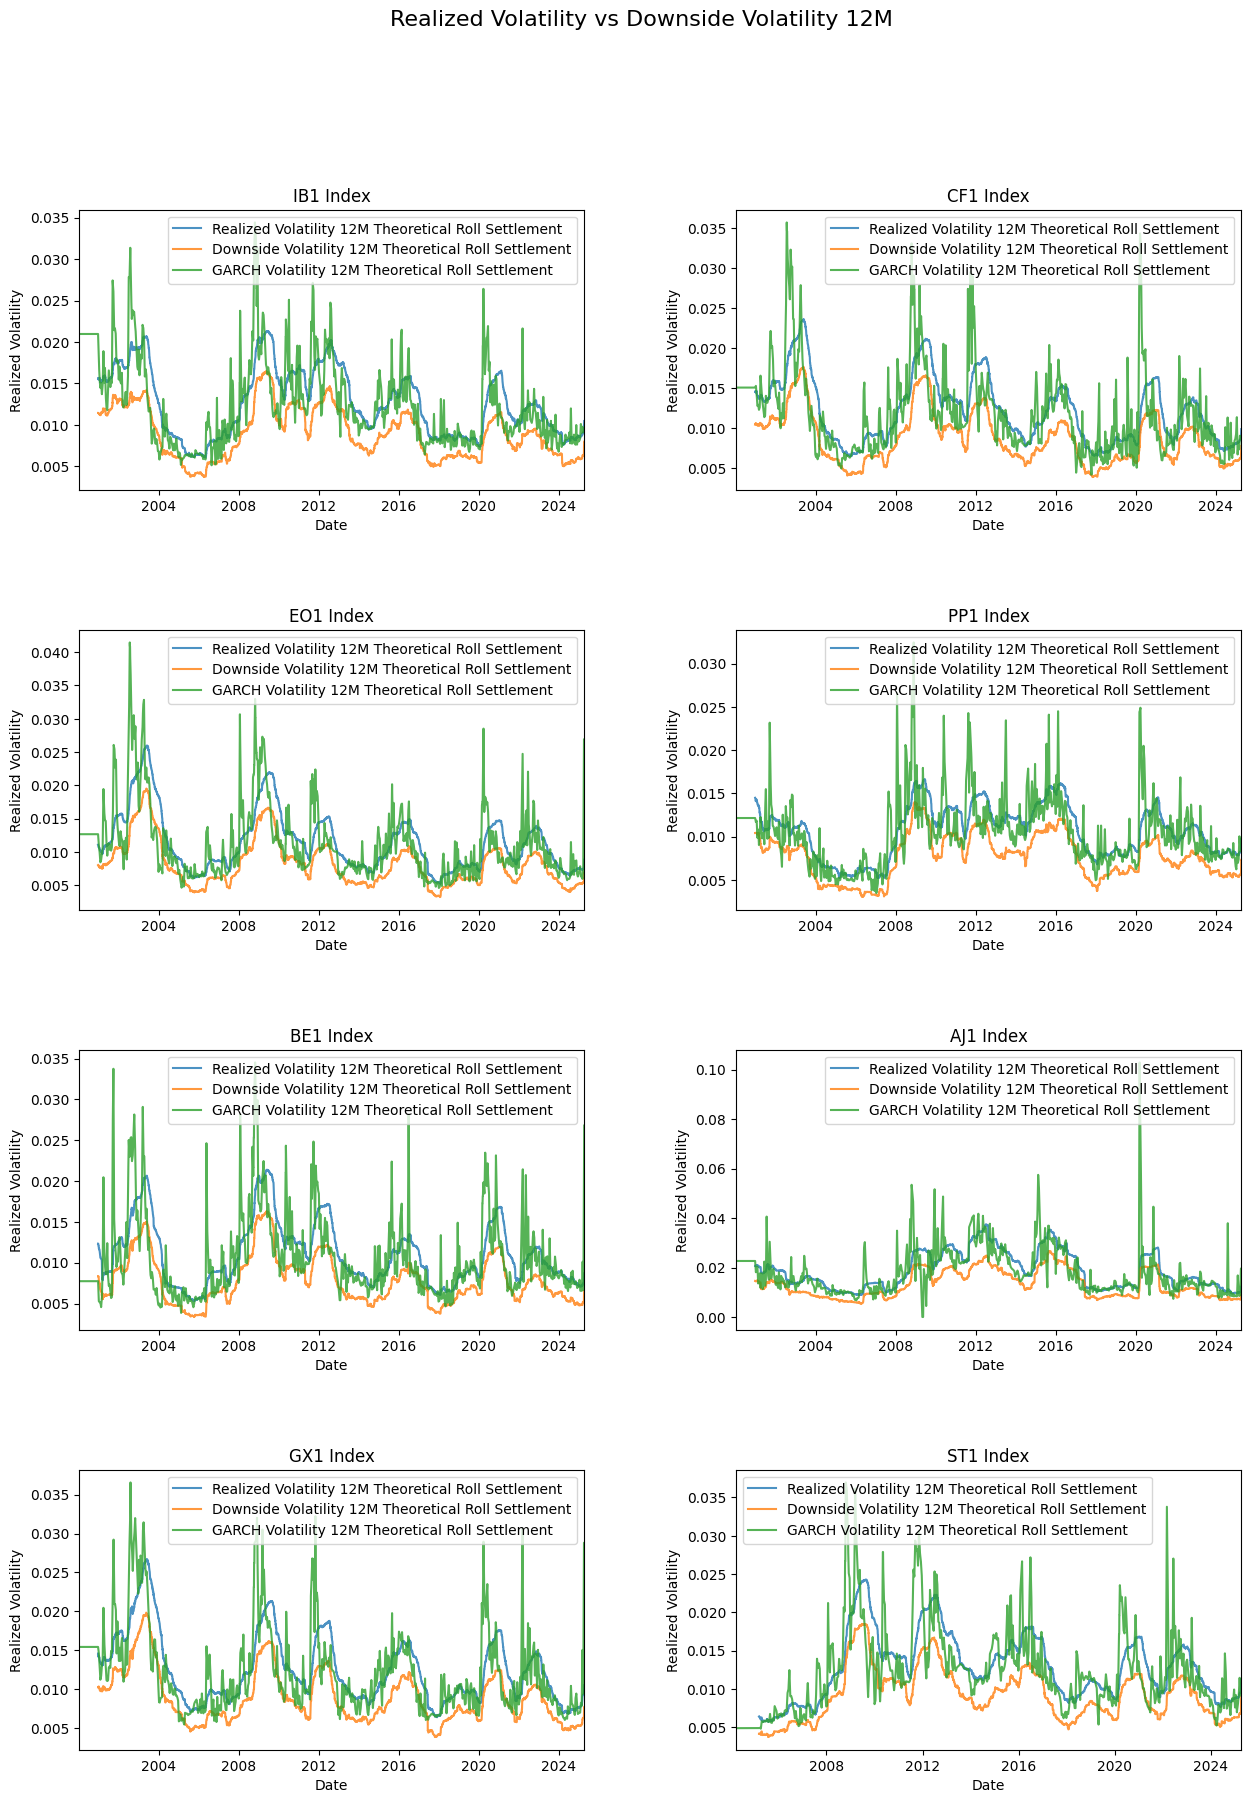

In [23]:
# Now for all futures we plot the realized volatility vs the downside volatility and GARCH
# Here, 12M
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Realized Volatility vs Downside Volatility 12M', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (i, future) in enumerate(enumerate(futures_euroindex)):
    ax = axes[idx // 2, idx % 2]
    
    ax.plot(future.realized_vol_roll_12MROLL.index,
            future.realized_vol_roll_12MROLL, 
            label='Realized Volatility 12M Theoretical Roll Settlement', alpha=0.8)
    ax.plot(future.realized_downside_vol_roll_12MROLL.index,
            future.realized_downside_vol_roll_12MROLL, 
            label='Downside Volatility 12M Theoretical Roll Settlement', alpha=0.8)
    ax.plot(future.garch_volatility_12MROLL.index,
            future.garch_volatility_12MROLL, 
            label='GARCH Volatility 12M Theoretical Roll Settlement', alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()
    
# Eliminating the axes that are not used
for i in range(idx + 1, 8):
    fig.delaxes(axes[i // 2, i % 2])
plt.show()

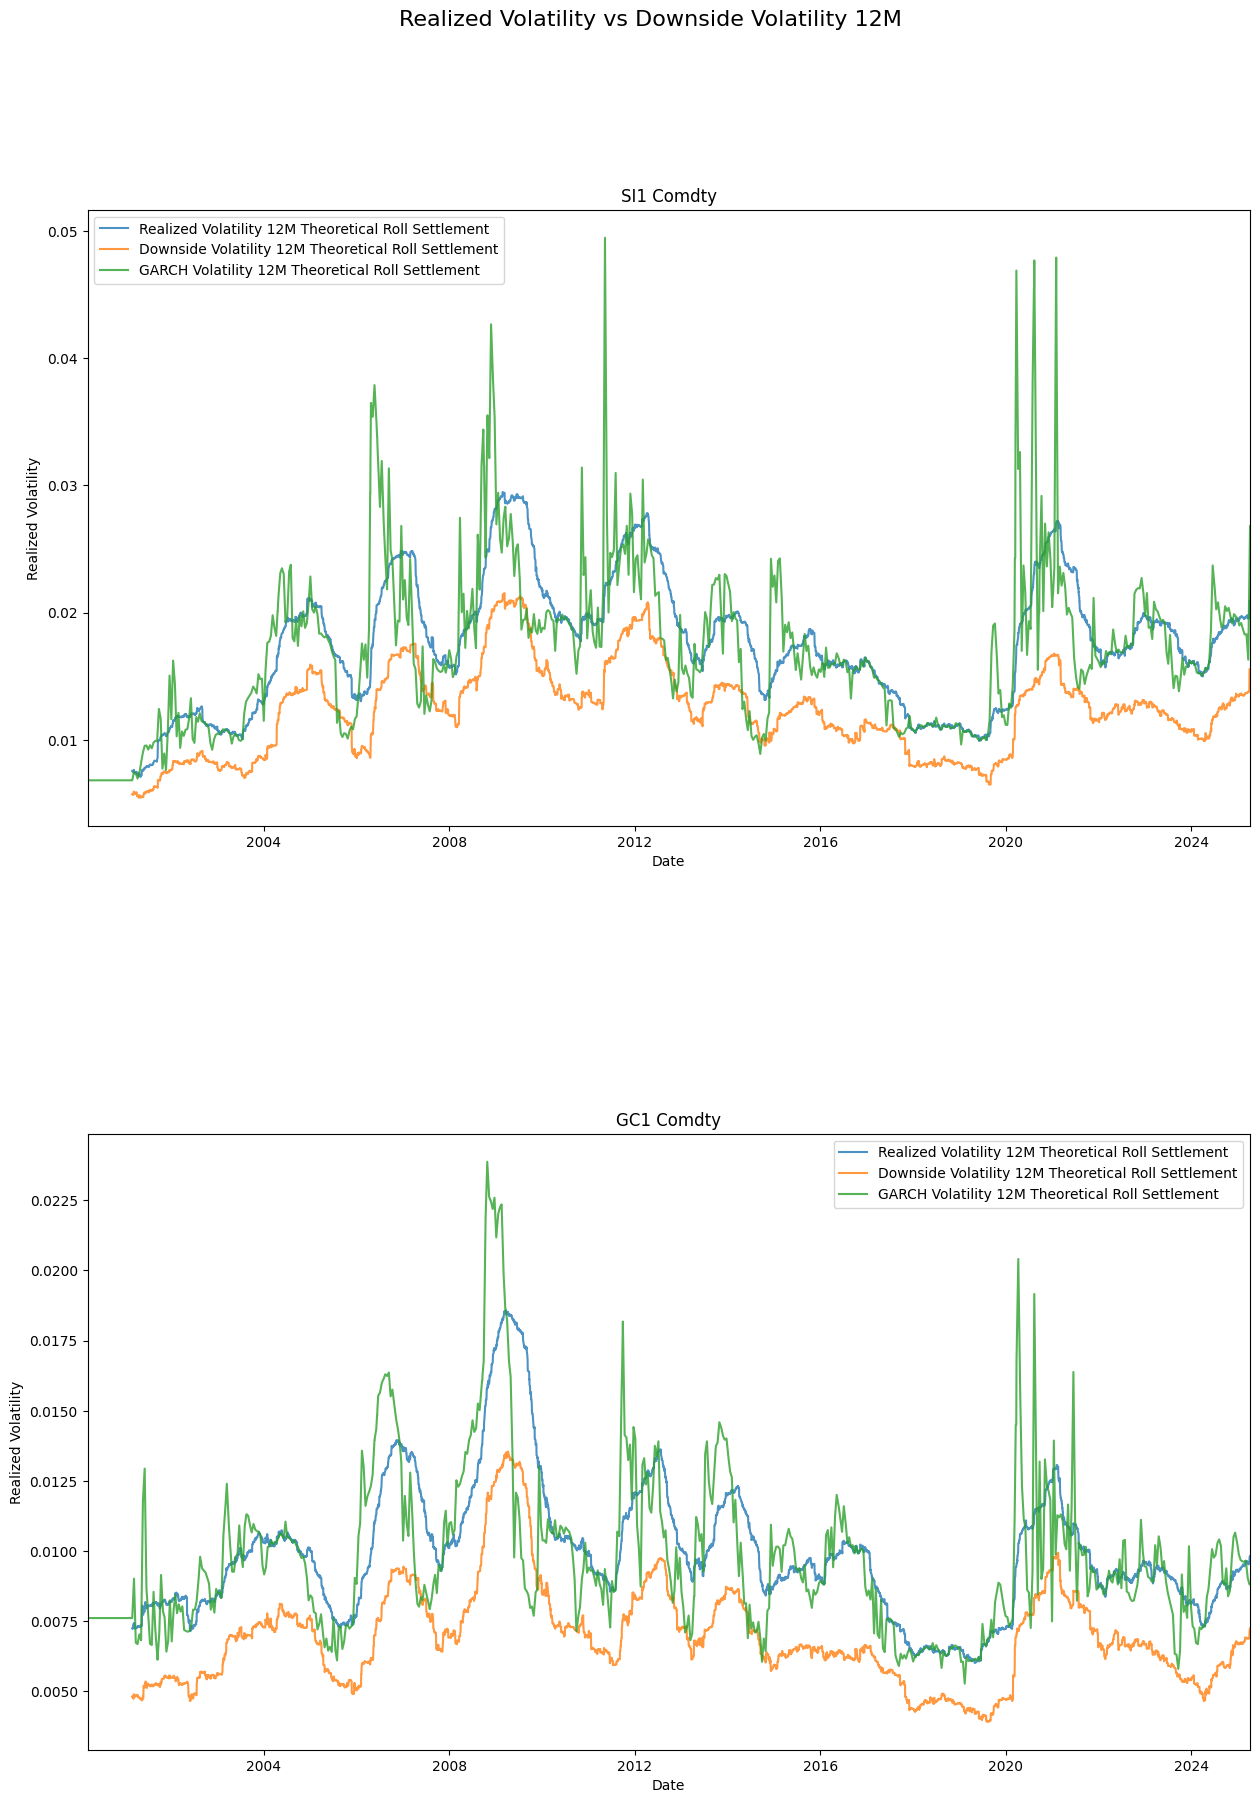

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(15, 20))
fig.suptitle('Realized Volatility vs Downside Volatility 12M', fontsize=16)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (i, future) in enumerate(enumerate(futures_metals)):
    ax = axes[idx]
    
    ax.plot(future.realized_vol_roll_12MROLL.index,
            future.realized_vol_roll_12MROLL, 
            label='Realized Volatility 12M Theoretical Roll Settlement', alpha=0.8)
    ax.plot(future.realized_downside_vol_roll_12MROLL.index,
            future.realized_downside_vol_roll_12MROLL, 
            label='Downside Volatility 12M Theoretical Roll Settlement', alpha=0.8)
    ax.plot(future.garch_volatility_12MROLL.index,
            future.garch_volatility_12MROLL, 
            label='GARCH Volatility 12M Theoretical Roll Settlement', alpha=0.8)
    ax.set_xlim([future.get_first_data_date(), future.roll_settle_theoretical.index[-1]])
    ax.set_title(future.name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Realized Volatility')
    ax.legend()
plt.show()

In [25]:
# For now eliminating Greece from futures
futures_euroindex = [future for future in futures_euroindex if future.name != 'AJ1 Index']

In [26]:
# All futures, without Greece, but with metals
futures_all = futures_euroindex + futures_metals

In [27]:
# Defining a volatility managed strategy
# Inverse variance weighting and also one equal weight
strategy_vol = pb.Strategy(name='Volatility managed - test', futures=futures_all, strategy_type='INVERSE_VARIANCE', base_currency='EUR', date_delta=10)
strategy_ew = pb.Strategy(name='Equal weighted - test', futures=futures_all, strategy_type='EQUAL_WEIGHTED', base_currency='EUR', date_delta=10)

In [28]:
# Getting the first date of the latest starting strategy
# sim_vol_managed_1MREBAL_12MEST_NORMVOL = strategy_vol.simulate_strategy_theoretical(strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='12M', volatility_method= 'REALIZED_VOL')
# first_date = sim_vol_managed_1MREBAL_12MEST_NORMVOL['Parameters']['Start date'].values[0]

# Setting first date to the 14th of April 2005
first_date = pd.to_datetime('2005-04-20')

In [29]:
max_attempts = 15
success = False

simulations_ntc = []
simulation_dict_ntc = {}

for offset in range(max_attempts):
    try:
        current_start_date = first_date + pd.Timedelta(days=offset)
        # For inverse variance using realized vol 
        sim_vol_1MREBAL_1MEST_NORMVOL_NTC = strategy_vol.simulate_strategy_ntc(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='1M', volatility_method='REALIZED_VOL', start_date=current_start_date)
        sim_vol_1MREBAL_3MEST_NORMVOL_NTC = strategy_vol.simulate_strategy_ntc(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='3M', volatility_method='REALIZED_VOL', start_date=current_start_date)
        sim_vol_1MREBAL_6MEST_NORMVOL_NTC = strategy_vol.simulate_strategy_ntc(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='6M', volatility_method='REALIZED_VOL', start_date=current_start_date)
        sim_vol_1MREBAL_12MEST_NORMVOL_NTC = strategy_vol.simulate_strategy_ntc(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='12M', volatility_method='REALIZED_VOL', start_date=current_start_date)

        # For inverse variance using downside vol
        sim_vol_1MREBAL_1MEST_DOWNVOL_NTC = strategy_vol.simulate_strategy_ntc(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='1M', volatility_method='DOWNSIDE_VOL', start_date=current_start_date)
        sim_vol_1MREBAL_3MEST_DOWNVOL_NTC = strategy_vol.simulate_strategy_ntc(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='3M', volatility_method='DOWNSIDE_VOL', start_date=current_start_date)
        sim_vol_1MREBAL_6MEST_DOWNVOL_NTC = strategy_vol.simulate_strategy_ntc(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='6M', volatility_method='DOWNSIDE_VOL', start_date=current_start_date)
        sim_vol_1MREBAL_12MEST_DOWNVOL_NTC = strategy_vol.simulate_strategy_ntc(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='12M', volatility_method='DOWNSIDE_VOL', start_date=current_start_date)

        # For inverse variance using GARCH vol
        sim_vol_1MREBAL_1MEST_GARCH_NTC = strategy_vol.simulate_strategy_ntc(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='1M', volatility_method='GARCH', start_date=current_start_date)
        sim_vol_1MREBAL_3MEST_GARCH_NTC = strategy_vol.simulate_strategy_ntc(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='3M', volatility_method='GARCH', start_date=current_start_date)
        sim_vol_1MREBAL_6MEST_GARCH_NTC = strategy_vol.simulate_strategy_ntc(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='6M', volatility_method='GARCH', start_date=current_start_date)
        sim_vol_1MREBAL_12MEST_GARCH_NTC = strategy_vol.simulate_strategy_ntc(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='12M', volatility_method='GARCH', start_date=current_start_date)

        # For equal weighted strategy (benchmark)
        sim_ew_1MREBAL_NTC = strategy_ew.simulate_strategy_ntc(
            strategy_type=strategy_ew.strategy_type, rebalance_frequency='1M', start_date=current_start_date)

        # Store the simulations
        simulations_ntc.append({
            'start_date': current_start_date,
            'sim_vol_1MREBAL_1MEST_NORMVOL': sim_vol_1MREBAL_1MEST_NORMVOL_NTC,
            'sim_vol_1MREBAL_3MEST_NORMVOL': sim_vol_1MREBAL_3MEST_NORMVOL_NTC,
            'sim_vol_1MREBAL_6MEST_NORMVOL': sim_vol_1MREBAL_6MEST_NORMVOL_NTC,
            'sim_vol_1MREBAL_12MEST_NORMVOL': sim_vol_1MREBAL_12MEST_NORMVOL_NTC,
            'sim_vol_1MREBAL_1MEST_DOWNVOL': sim_vol_1MREBAL_1MEST_DOWNVOL_NTC,
            'sim_vol_1MREBAL_3MEST_DOWNVOL': sim_vol_1MREBAL_3MEST_DOWNVOL_NTC,
            'sim_vol_1MREBAL_6MEST_DOWNVOL': sim_vol_1MREBAL_6MEST_DOWNVOL_NTC,
            'sim_vol_1MREBAL_12MEST_DOWNVOL': sim_vol_1MREBAL_12MEST_DOWNVOL_NTC,
            'sim_vol_1MREBAL_1MEST_GARCH': sim_vol_1MREBAL_1MEST_GARCH_NTC,
            'sim_vol_1MREBAL_3MEST_GARCH': sim_vol_1MREBAL_3MEST_GARCH_NTC,
            'sim_vol_1MREBAL_6MEST_GARCH': sim_vol_1MREBAL_6MEST_GARCH_NTC,
            'sim_vol_1MREBAL_12MEST_GARCH': sim_vol_1MREBAL_12MEST_GARCH_NTC,
            'sim_ew_1MREBAL_NTC': sim_ew_1MREBAL_NTC
        })
        print(f"Simulation succeeded with start_date: {current_start_date}")
        success = True

        # Build a dictionary for easy access
        simulation_dict_ntc = {
            'sim_vol_1MREBAL_1MEST_NORMVOL': sim_vol_1MREBAL_1MEST_NORMVOL_NTC,
            'sim_vol_1MREBAL_3MEST_NORMVOL': sim_vol_1MREBAL_3MEST_NORMVOL_NTC,
            'sim_vol_1MREBAL_6MEST_NORMVOL': sim_vol_1MREBAL_6MEST_NORMVOL_NTC,
            'sim_vol_1MREBAL_12MEST_NORMVOL': sim_vol_1MREBAL_12MEST_NORMVOL_NTC,
            'sim_vol_1MREBAL_1MEST_DOWNVOL': sim_vol_1MREBAL_1MEST_DOWNVOL_NTC,
            'sim_vol_1MREBAL_3MEST_DOWNVOL': sim_vol_1MREBAL_3MEST_DOWNVOL_NTC,
            'sim_vol_1MREBAL_6MEST_DOWNVOL': sim_vol_1MREBAL_6MEST_DOWNVOL_NTC,
            'sim_vol_1MREBAL_12MEST_DOWNVOL': sim_vol_1MREBAL_12MEST_DOWNVOL_NTC,
            'sim_vol_1MREBAL_1MEST_GARCH': sim_vol_1MREBAL_1MEST_GARCH_NTC,
            'sim_vol_1MREBAL_3MEST_GARCH': sim_vol_1MREBAL_3MEST_GARCH_NTC,
            'sim_vol_1MREBAL_6MEST_GARCH': sim_vol_1MREBAL_6MEST_GARCH_NTC,
            'sim_vol_1MREBAL_12MEST_GARCH': sim_vol_1MREBAL_12MEST_GARCH_NTC,
            'sim_ew_1MREBAL_NTC': sim_ew_1MREBAL_NTC
        }
        break  # Stop after first successful simulation

    except Exception as e:
        print(f"Simulation failed for start_date {current_start_date}: {e}")

if not success:
    print("Simulation failed for all attempted start dates.")

Simulation succeeded with start_date: 2005-04-20 00:00:00


In [49]:
max_attempts = 15
success = False

simulations = []
for offset in range(0, max_attempts):
    try:
        current_start_date = first_date + pd.Timedelta(days=offset)
        # For inverse variance using realized vol 
        sim_vol_1MREBAL_1MEST_NORMVOL = strategy_vol.simulate_strategy_theoretical(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='1M', volatility_method= 'REALIZED_VOL', start_date=current_start_date)
        sim_vol_1MREBAL_3MEST_NORMVOL = strategy_vol.simulate_strategy_theoretical(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='3M', volatility_method= 'REALIZED_VOL', start_date=current_start_date)
        sim_vol_1MREBAL_6MEST_NORMVOL = strategy_vol.simulate_strategy_theoretical(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='6M', volatility_method= 'REALIZED_VOL', start_date=current_start_date)
        sim_vol_1MREBAL_12MEST_NORMVOL = strategy_vol.simulate_strategy_theoretical(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='12M', volatility_method= 'REALIZED_VOL', start_date=current_start_date)
        
        # For inverse variance using downside vol
        sim_vol_1MREBAL_1MEST_DOWNVOL = strategy_vol.simulate_strategy_theoretical(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='1M', volatility_method= 'DOWNSIDE_VOL', start_date=current_start_date)
        sim_vol_1MREBAL_3MEST_DOWNVOL = strategy_vol.simulate_strategy_theoretical(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='3M', volatility_method= 'DOWNSIDE_VOL', start_date=current_start_date)
        sim_vol_1MREBAL_6MEST_DOWNVOL = strategy_vol.simulate_strategy_theoretical(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='6M', volatility_method= 'DOWNSIDE_VOL', start_date=current_start_date)
        sim_vol_1MREBAL_12MEST_DOWNVOL = strategy_vol.simulate_strategy_theoretical(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='12M', volatility_method= 'DOWNSIDE_VOL', start_date=current_start_date)
        
        # For inverse variance using GARCH vol
        sim_vol_1MREBAL_1MEST_GARCH = strategy_vol.simulate_strategy_theoretical(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='1M', volatility_method= 'GARCH', start_date=current_start_date)
        sim_vol_1MREBAL_3MEST_GARCH = strategy_vol.simulate_strategy_theoretical(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='3M', volatility_method= 'GARCH', start_date=current_start_date)
        sim_vol_1MREBAL_6MEST_GARCH = strategy_vol.simulate_strategy_theoretical(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='6M', volatility_method= 'GARCH', start_date=current_start_date)
        sim_vol_1MREBAL_12MEST_GARCH = strategy_vol.simulate_strategy_theoretical(
            strategy_type='INVERSE_VARIANCE', rebalance_frequency='1M', estimation_window='12M', volatility_method= 'GARCH', start_date=current_start_date)
        
        # For equal weighted strategy (Maybe a benchmark)
        sim_ew_1MREBAL = strategy_ew.simulate_strategy_theoretical(
            strategy_type=strategy_ew.strategy_type, rebalance_frequency='1M', start_date=current_start_date)
        
        # Store the simulations
        simulations.append({
            'start_date': current_start_date,
            'sim_vol_1MREBAL_1MEST_NORMVOL': sim_vol_1MREBAL_1MEST_NORMVOL,
            'sim_vol_1MREBAL_3MEST_NORMVOL': sim_vol_1MREBAL_3MEST_NORMVOL,
            'sim_vol_1MREBAL_6MEST_NORMVOL': sim_vol_1MREBAL_6MEST_NORMVOL,
            'sim_vol_1MREBAL_12MEST_NORMVOL': sim_vol_1MREBAL_12MEST_NORMVOL,
            'sim_vol_1MREBAL_1MEST_DOWNVOL': sim_vol_1MREBAL_1MEST_DOWNVOL,
            'sim_vol_1MREBAL_3MEST_DOWNVOL': sim_vol_1MREBAL_3MEST_DOWNVOL,
            'sim_vol_1MREBAL_6MEST_DOWNVOL': sim_vol_1MREBAL_6MEST_DOWNVOL,
            'sim_vol_1MREBAL_12MEST_DOWNVOL': sim_vol_1MREBAL_12MEST_DOWNVOL,
            'sim_vol_1MREBAL_1MEST_GARCH': sim_vol_1MREBAL_1MEST_GARCH,
            'sim_vol_1MREBAL_3MEST_GARCH': sim_vol_1MREBAL_3MEST_GARCH,
            'sim_vol_1MREBAL_6MEST_GARCH': sim_vol_1MREBAL_6MEST_GARCH,
            'sim_vol_1MREBAL_12MEST_GARCH': sim_vol_1MREBAL_12MEST_GARCH,
            'sim_ew_1MREBAL': sim_ew_1MREBAL
        })
        print(f"Simulation succeeded with start_date: {current_start_date}")
        success = True
        
        # Building a dictionary with all the simulations and simulation names
        simulation_dict = {
            'sim_vol_1MREBAL_1MEST_NORMVOL': sim_vol_1MREBAL_1MEST_NORMVOL,
            'sim_vol_1MREBAL_3MEST_NORMVOL': sim_vol_1MREBAL_3MEST_NORMVOL,
            'sim_vol_1MREBAL_6MEST_NORMVOL': sim_vol_1MREBAL_6MEST_NORMVOL,
            'sim_vol_1MREBAL_12MEST_NORMVOL': sim_vol_1MREBAL_12MEST_NORMVOL,
            'sim_vol_1MREBAL_1MEST_DOWNVOL': sim_vol_1MREBAL_1MEST_DOWNVOL,
            'sim_vol_1MREBAL_3MEST_DOWNVOL': sim_vol_1MREBAL_3MEST_DOWNVOL,
            'sim_vol_1MREBAL_6MEST_DOWNVOL': sim_vol_1MREBAL_6MEST_DOWNVOL,
            'sim_vol_1MREBAL_12MEST_DOWNVOL': sim_vol_1MREBAL_12MEST_DOWNVOL,
            'sim_vol_1MREBAL_1MEST_GARCH': sim_vol_1MREBAL_1MEST_GARCH,
            'sim_vol_1MREBAL_3MEST_GARCH': sim_vol_1MREBAL_3MEST_GARCH,
            'sim_vol_1MREBAL_6MEST_GARCH': sim_vol_1MREBAL_6MEST_GARCH,
            'sim_vol_1MREBAL_12MEST_GARCH': sim_vol_1MREBAL_12MEST_GARCH,
            'sim_ew_1MREBAL': sim_ew_1MREBAL
        }
        break
    except Exception as e:
        print(f"Simulation failed for start_date {current_start_date}: {e}")

if not success:
    print("Simulation failed for all attempted start dates.")

Simulation succeeded with start_date: 2005-04-20 00:00:00


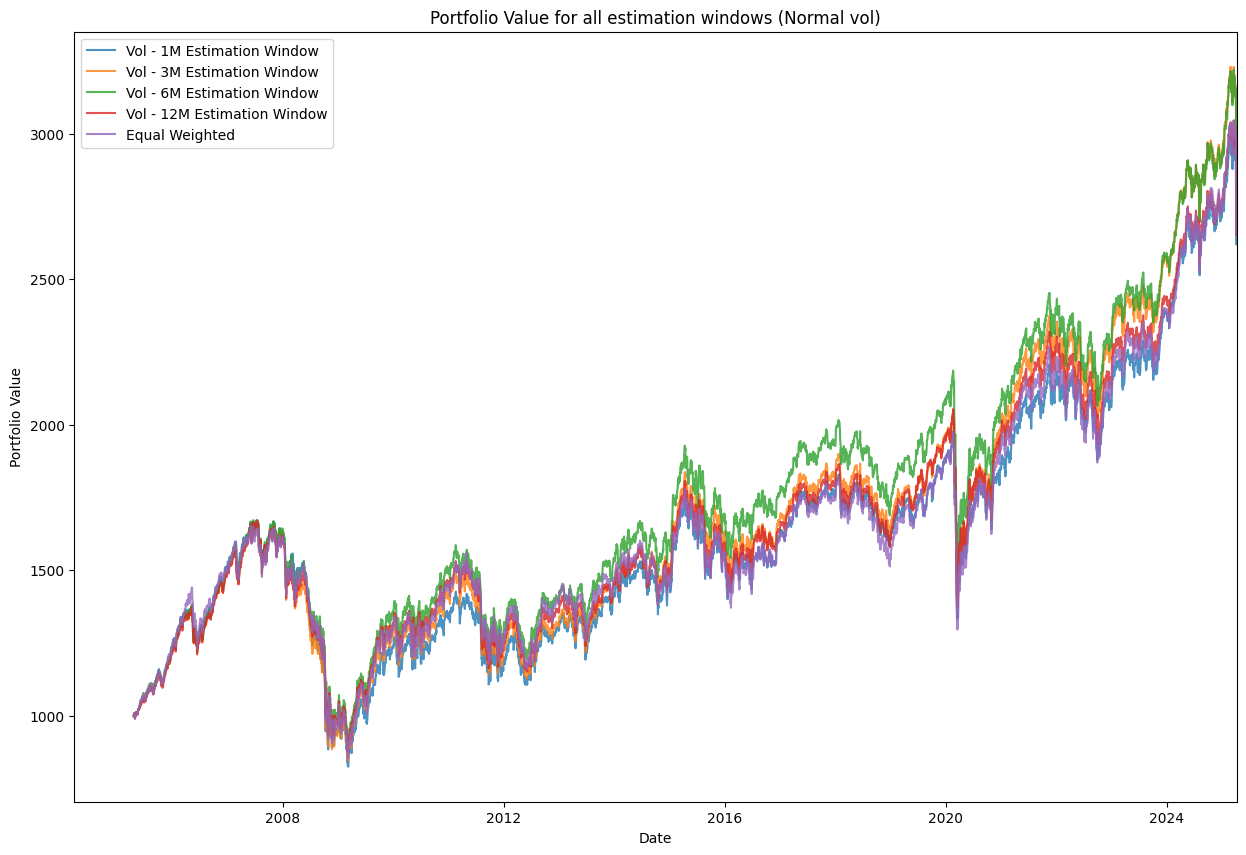

In [ ]:
# Plotting Portfolio value for all inverse variance strategies with only realized vol
# Same plot
fig, ax = plt.subplots(figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax.plot(sim_vol_1MREBAL_1MEST_NORMVOL_NTC['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_1MEST_NORMVOL_NTC['Portfolio']['Portfolio value'], label='Vol - 1M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_3MEST_NORMVOL_NTC['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_3MEST_NORMVOL_NTC['Portfolio']['Portfolio value'], label='Vol - 3M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_6MEST_NORMVOL_NTC['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_6MEST_NORMVOL_NTC['Portfolio']['Portfolio value'], label='Vol - 6M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_12MEST_NORMVOL_NTC['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_12MEST_NORMVOL_NTC['Portfolio']['Portfolio value'], label='Vol - 12M Estimation Window', alpha=0.8)
ax.plot(sim_ew_1MREBAL_NTC['Portfolio']['Portfolio value'].index, sim_ew_1MREBAL_NTC['Portfolio']['Portfolio value'], label='Equal Weighted', alpha=0.8)
ax.set_xlim([strategy_ew.start_date, strategy_ew.end_date])
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.legend()
plt.show()

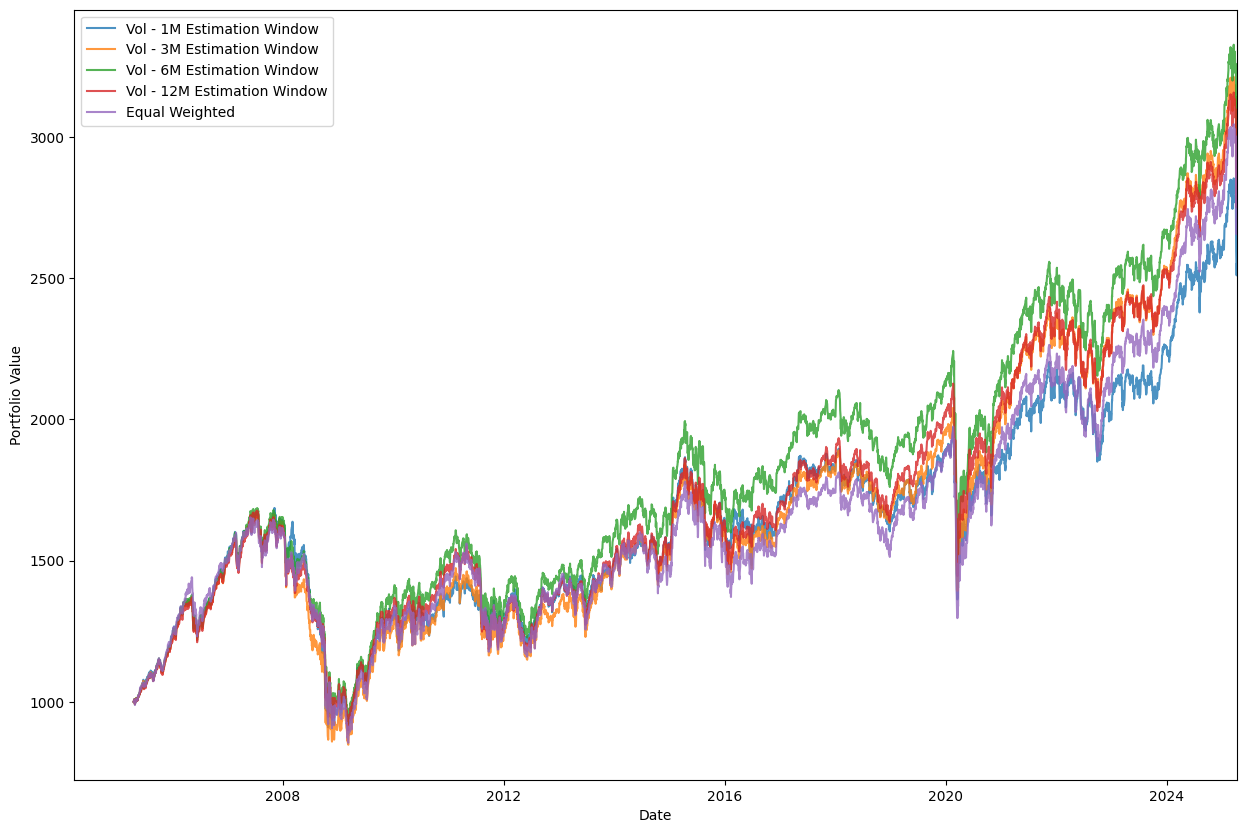

In [48]:
# Plotting Portfolio value for all inverse variance strategies with only realized vol
# Same plot
fig, ax = plt.subplots(figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax.plot(sim_vol_1MREBAL_1MEST_DOWNVOL_NTC['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_1MEST_DOWNVOL_NTC['Portfolio']['Portfolio value'], label='Vol - 1M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_3MEST_DOWNVOL_NTC['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_3MEST_DOWNVOL_NTC['Portfolio']['Portfolio value'], label='Vol - 3M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_6MEST_DOWNVOL_NTC['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_6MEST_DOWNVOL_NTC['Portfolio']['Portfolio value'], label='Vol - 6M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_12MEST_DOWNVOL_NTC['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_12MEST_DOWNVOL_NTC['Portfolio']['Portfolio value'], label='Vol - 12M Estimation Window', alpha=0.8)
ax.plot(sim_ew_1MREBAL_NTC['Portfolio']['Portfolio value'].index, sim_ew_1MREBAL_NTC['Portfolio']['Portfolio value'], label='Equal Weighted', alpha=0.8)
ax.set_xlim([strategy_ew.start_date, strategy_ew.end_date])
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.legend()
plt.show()

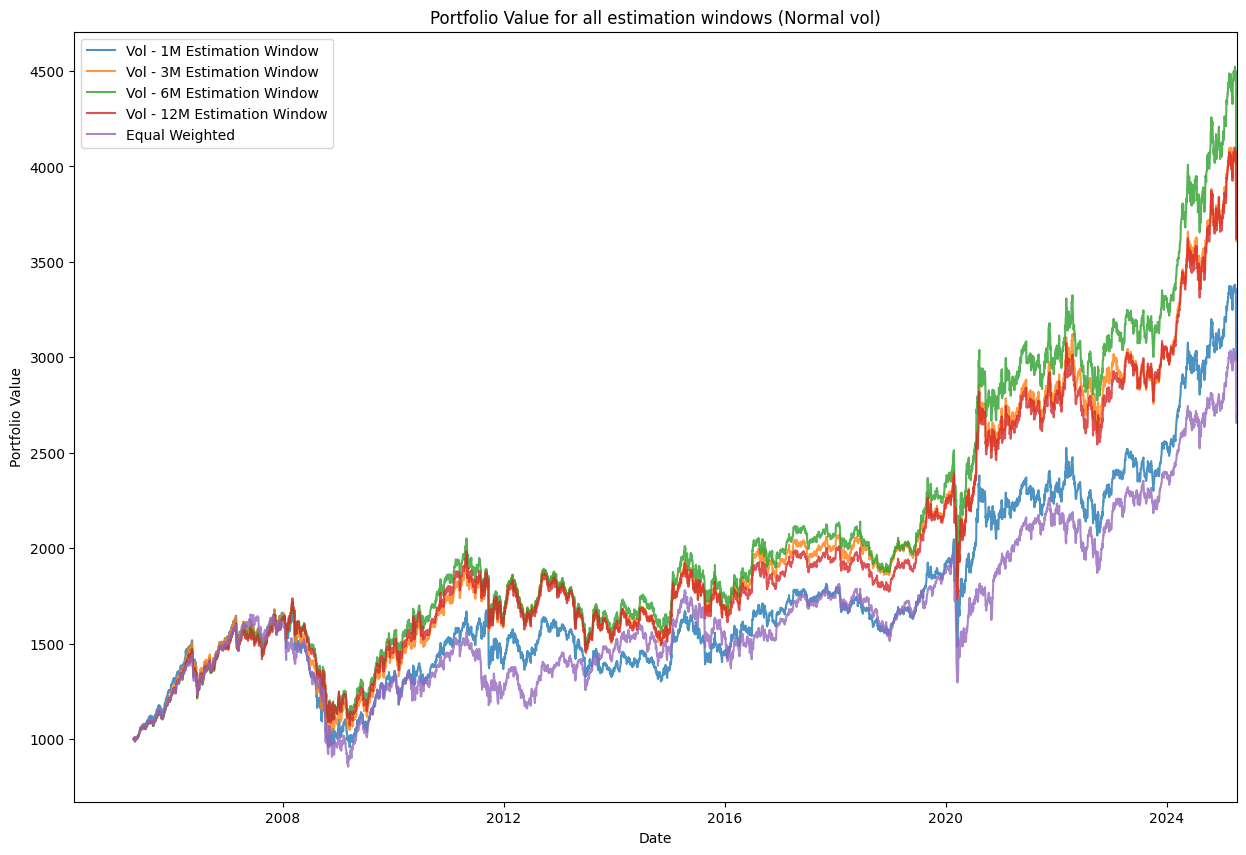

In [ ]:
# Plotting Portfolio value for all inverse variance strategies with only realized vol
# Same plot
fig, ax = plt.subplots(figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax.plot(sim_vol_1MREBAL_1MEST_GARCH_NTC['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_1MEST_GARCH_NTC['Portfolio']['Portfolio value'], label='Vol - 1M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_3MEST_GARCH_NTC['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_3MEST_GARCH_NTC['Portfolio']['Portfolio value'], label='Vol - 3M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_6MEST_GARCH_NTC['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_6MEST_GARCH_NTC['Portfolio']['Portfolio value'], label='Vol - 6M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_12MEST_GARCH_NTC['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_12MEST_GARCH_NTC['Portfolio']['Portfolio value'], label='Vol - 12M Estimation Window', alpha=0.8)
ax.plot(sim_ew_1MREBAL_NTC['Portfolio']['Portfolio value'].index, sim_ew_1MREBAL_NTC['Portfolio']['Portfolio value'], label='Equal Weighted', alpha=0.8)
ax.set_xlim([strategy_ew.start_date, strategy_ew.end_date])
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.legend()
plt.show()

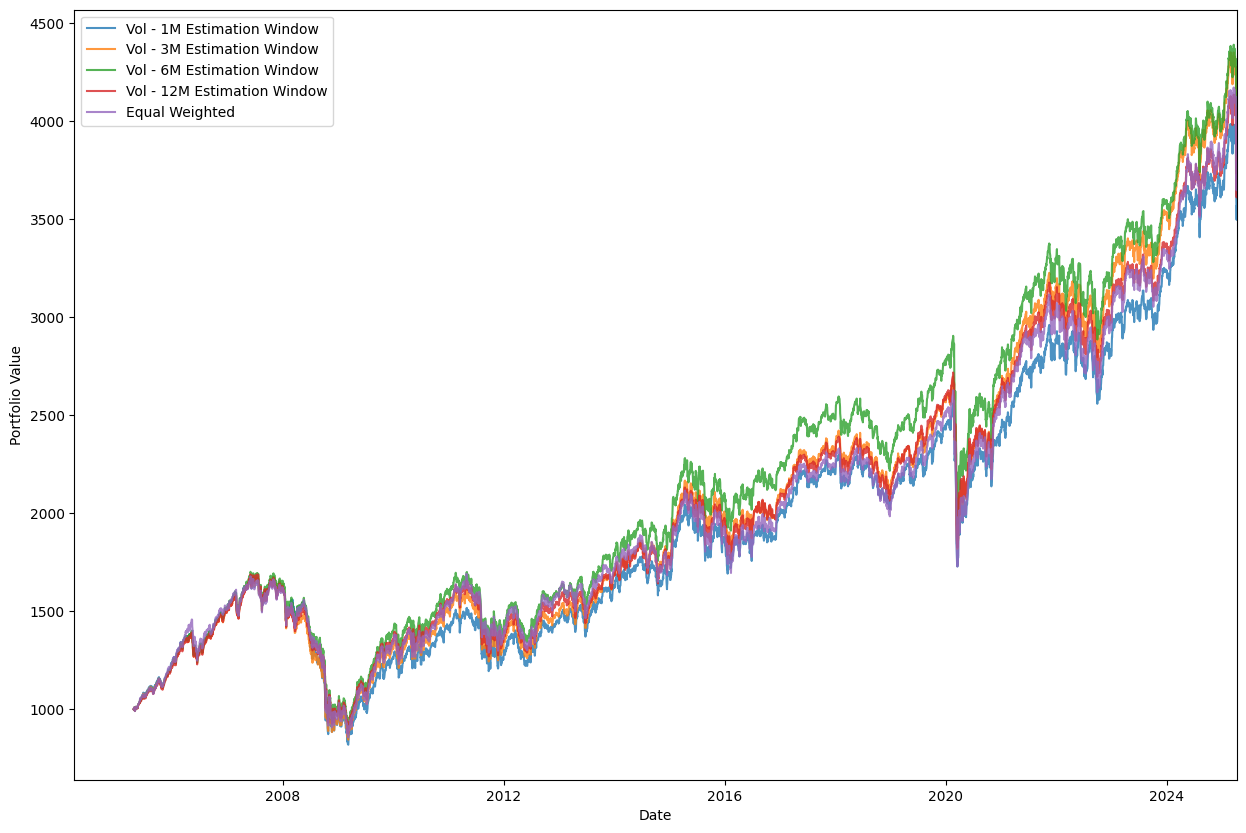

In [50]:
# Plotting Portfolio value for all inverse variance strategies with only realized vol
# Same plot
fig, ax = plt.subplots(figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax.plot(sim_vol_1MREBAL_1MEST_NORMVOL['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_1MEST_NORMVOL['Portfolio']['Portfolio value'], label='Vol - 1M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_3MEST_NORMVOL['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_3MEST_NORMVOL['Portfolio']['Portfolio value'], label='Vol - 3M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_6MEST_NORMVOL['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_6MEST_NORMVOL['Portfolio']['Portfolio value'], label='Vol - 6M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_12MEST_NORMVOL['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_12MEST_NORMVOL['Portfolio']['Portfolio value'], label='Vol - 12M Estimation Window', alpha=0.8)
ax.plot(sim_ew_1MREBAL['Portfolio']['Portfolio value'].index, sim_ew_1MREBAL['Portfolio']['Portfolio value'], label='Equal Weighted', alpha=0.8)
ax.set_xlim([strategy_ew.start_date, strategy_ew.end_date])
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.legend()
plt.show()

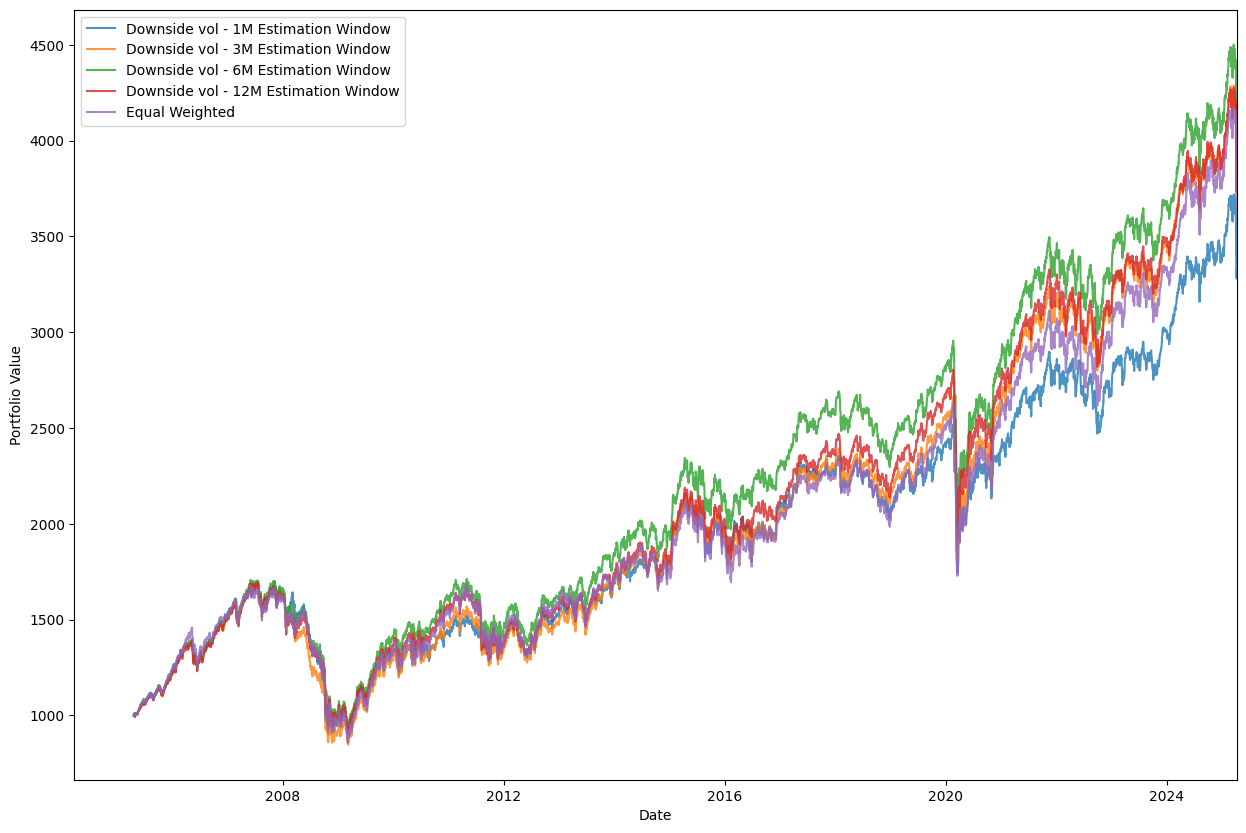

In [51]:
# Plotting Portfolio value for all inverse variance strategies with only downside vol
# Same plot
fig, ax = plt.subplots(figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax.plot(sim_vol_1MREBAL_1MEST_DOWNVOL['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_1MEST_DOWNVOL['Portfolio']['Portfolio value'], label='Downside vol - 1M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_3MEST_DOWNVOL['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_3MEST_DOWNVOL['Portfolio']['Portfolio value'], label='Downside vol - 3M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_6MEST_DOWNVOL['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_6MEST_DOWNVOL['Portfolio']['Portfolio value'], label='Downside vol - 6M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_12MEST_DOWNVOL['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_12MEST_DOWNVOL['Portfolio']['Portfolio value'], label='Downside vol - 12M Estimation Window', alpha=0.8)
ax.plot(sim_ew_1MREBAL['Portfolio']['Portfolio value'].index, sim_ew_1MREBAL['Portfolio']['Portfolio value'], label='Equal Weighted', alpha=0.8)
ax.set_xlim([strategy_ew.start_date, strategy_ew.end_date])
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.legend()
plt.show()

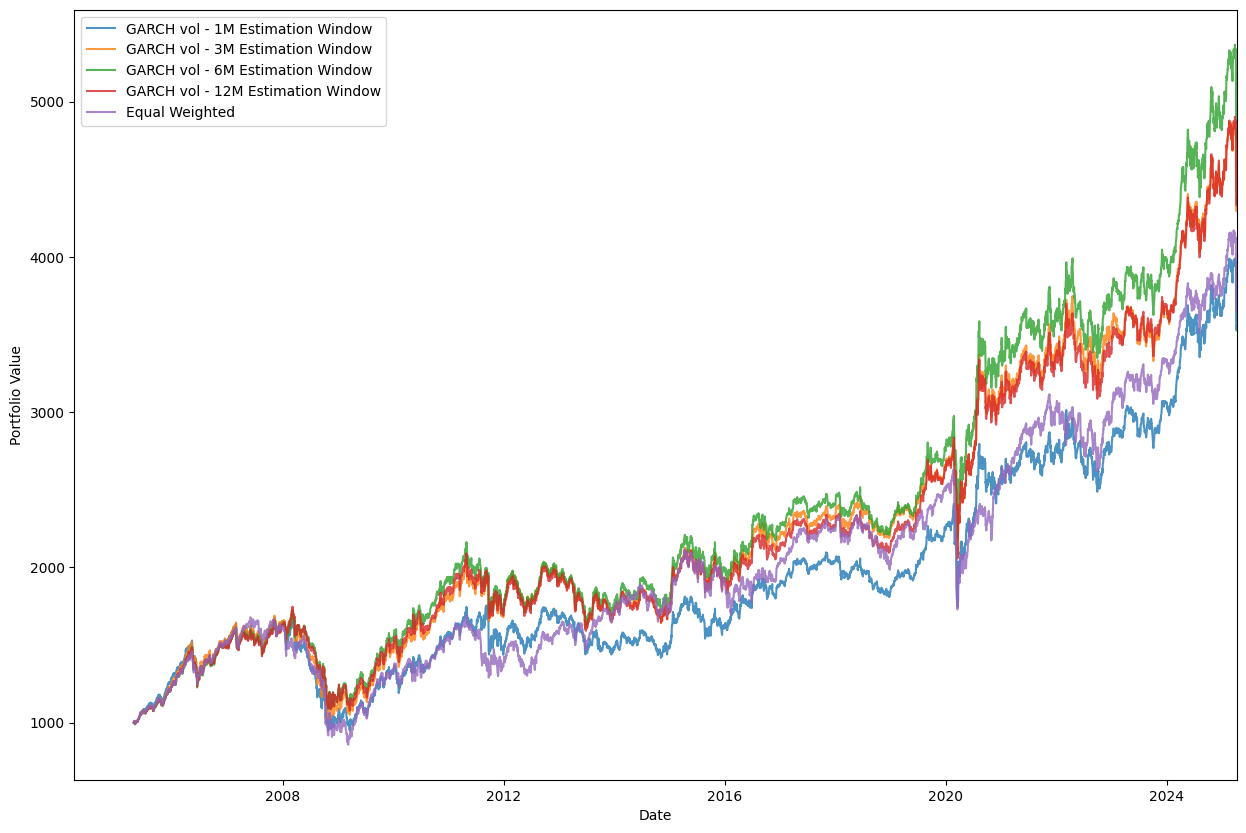

In [52]:
# Plotting Portfolio value for all inverse variance strategies with only GARCH vol
fig, ax = plt.subplots(figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax.plot(sim_vol_1MREBAL_1MEST_GARCH['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_1MEST_GARCH['Portfolio']['Portfolio value'], label='GARCH vol - 1M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_3MEST_GARCH['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_3MEST_GARCH['Portfolio']['Portfolio value'], label='GARCH vol - 3M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_6MEST_GARCH['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_6MEST_GARCH['Portfolio']['Portfolio value'], label='GARCH vol - 6M Estimation Window', alpha=0.8)
ax.plot(sim_vol_1MREBAL_12MEST_GARCH['Portfolio']['Portfolio value'].index, sim_vol_1MREBAL_12MEST_GARCH['Portfolio']['Portfolio value'], label='GARCH vol - 12M Estimation Window', alpha=0.8)
ax.plot(sim_ew_1MREBAL['Portfolio']['Portfolio value'].index, sim_ew_1MREBAL['Portfolio']['Portfolio value'], label='Equal Weighted', alpha=0.8)
ax.set_xlim([strategy_ew.start_date, strategy_ew.end_date])
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.legend()
plt.show()

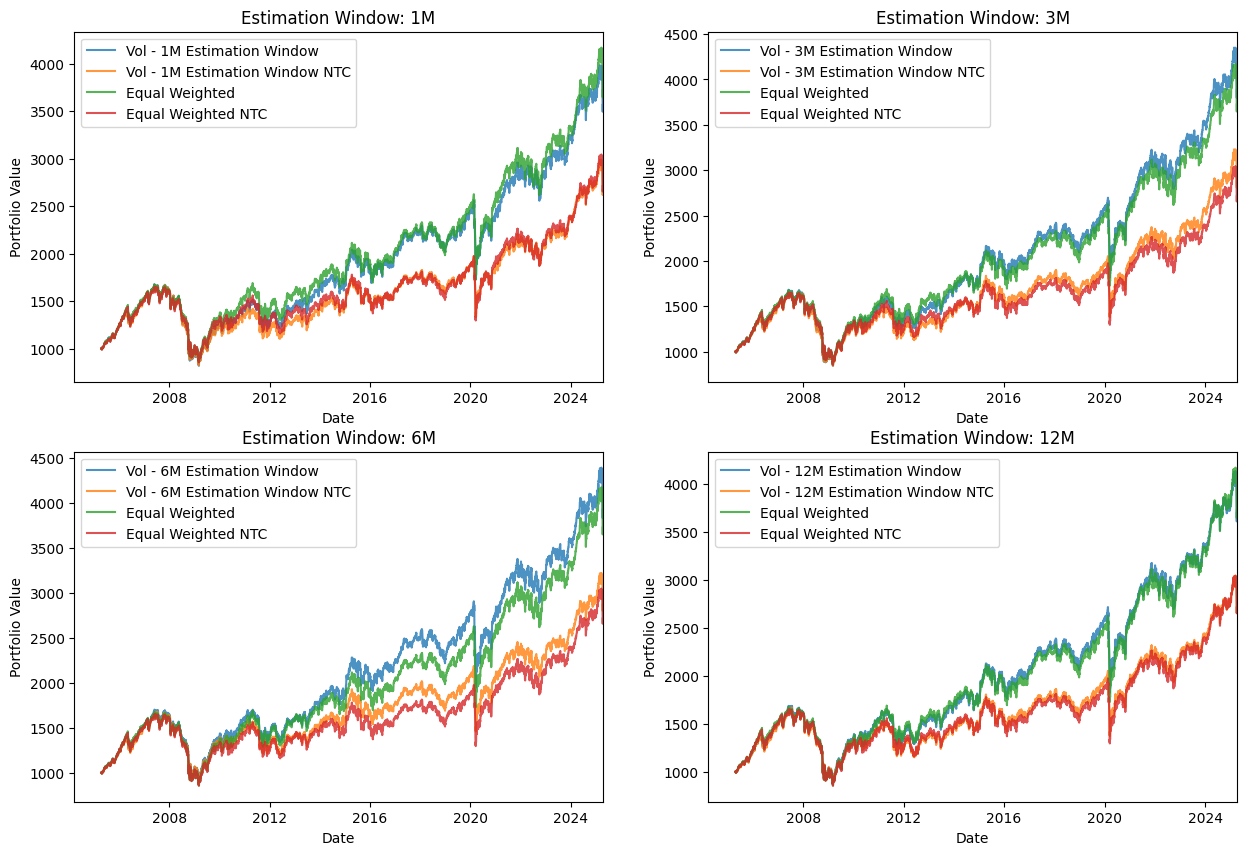

In [ ]:
# Plot: 2x2 Grid: For realized vol
# Each subplot: a different estimation window (1M, 3M, 6M, 12M)
# Each subplot has 4 lines: strategy, strategy NTC, EW, EW NTC

estimation_windows = [
    ('1M', sim_vol_1MREBAL_1MEST_NORMVOL, sim_vol_1MREBAL_1MEST_NORMVOL_NTC),
    ('3M', sim_vol_1MREBAL_3MEST_NORMVOL, sim_vol_1MREBAL_3MEST_NORMVOL_NTC),
    ('6M', sim_vol_1MREBAL_6MEST_NORMVOL, sim_vol_1MREBAL_6MEST_NORMVOL_NTC),
    ('12M', sim_vol_1MREBAL_12MEST_NORMVOL, sim_vol_1MREBAL_12MEST_NORMVOL_NTC),
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes_flat = axes.flatten()

for idx, (label, sim, sim_ntc) in enumerate(estimation_windows):
    ax = axes_flat[idx]
    ax.plot(sim['Portfolio']['Portfolio value'].index,
            sim['Portfolio']['Portfolio value'],
            label=f'Vol - {label} Estimation Window', alpha=0.8)
    ax.plot(sim_ntc['Portfolio']['Portfolio value'].index,
            sim_ntc['Portfolio']['Portfolio value'],
            label=f'Vol - {label} Estimation Window NTC', alpha=0.8)
    ax.plot(sim_ew_1MREBAL['Portfolio']['Portfolio value'].index,
            sim_ew_1MREBAL['Portfolio']['Portfolio value'],
            label='Equal Weighted', alpha=0.8)
    ax.plot(sim_ew_1MREBAL_NTC['Portfolio']['Portfolio value'].index,
            sim_ew_1MREBAL_NTC['Portfolio']['Portfolio value'],
            label='Equal Weighted NTC', alpha=0.8)
    ax.set_xlim([strategy_ew.start_date, strategy_ew.end_date])
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.set_title(f'Estimation Window: {label}')
    ax.legend()

plt.show()

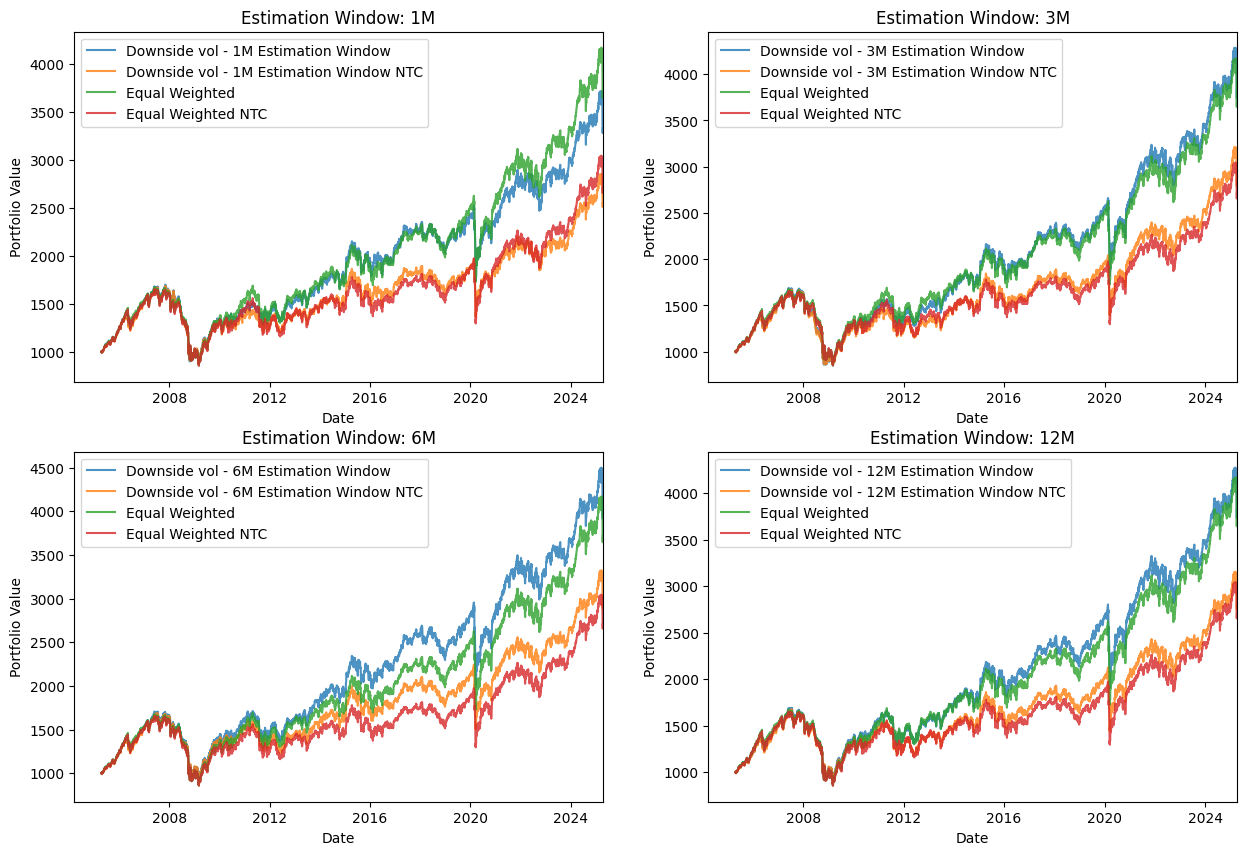

In [62]:
# Plot: 2x2 Grid: For downside vol
# Each subplot: a different estimation window (1M, 3M, 6M, 12M)
# Each subplot has 4 lines: strategy, strategy NTC, EW, EW NTC

estimation_windows = [
    ('1M', sim_vol_1MREBAL_1MEST_DOWNVOL, sim_vol_1MREBAL_1MEST_DOWNVOL_NTC),
    ('3M', sim_vol_1MREBAL_3MEST_DOWNVOL, sim_vol_1MREBAL_3MEST_DOWNVOL_NTC),
    ('6M', sim_vol_1MREBAL_6MEST_DOWNVOL, sim_vol_1MREBAL_6MEST_DOWNVOL_NTC),
    ('12M', sim_vol_1MREBAL_12MEST_DOWNVOL, sim_vol_1MREBAL_12MEST_DOWNVOL_NTC),
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axes_flat = axes.flatten()
for idx, (label, sim, sim_ntc) in enumerate(estimation_windows):
    ax = axes_flat[idx]
    ax.plot(sim['Portfolio']['Portfolio value'].index,
            sim['Portfolio']['Portfolio value'],
            label=f'Downside vol - {label} Estimation Window', alpha=0.8)
    ax.plot(sim_ntc['Portfolio']['Portfolio value'].index,
            sim_ntc['Portfolio']['Portfolio value'],
            label=f'Downside vol - {label} Estimation Window NTC', alpha=0.8)
    ax.plot(sim_ew_1MREBAL['Portfolio']['Portfolio value'].index,
            sim_ew_1MREBAL['Portfolio']['Portfolio value'],
            label='Equal Weighted', alpha=0.8)
    ax.plot(sim_ew_1MREBAL_NTC['Portfolio']['Portfolio value'].index,
            sim_ew_1MREBAL_NTC['Portfolio']['Portfolio value'],
            label='Equal Weighted NTC', alpha=0.8)
    ax.set_xlim([strategy_ew.start_date, strategy_ew.end_date])
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.set_title(f'Estimation Window: {label}')
    ax.legend()
plt.show()

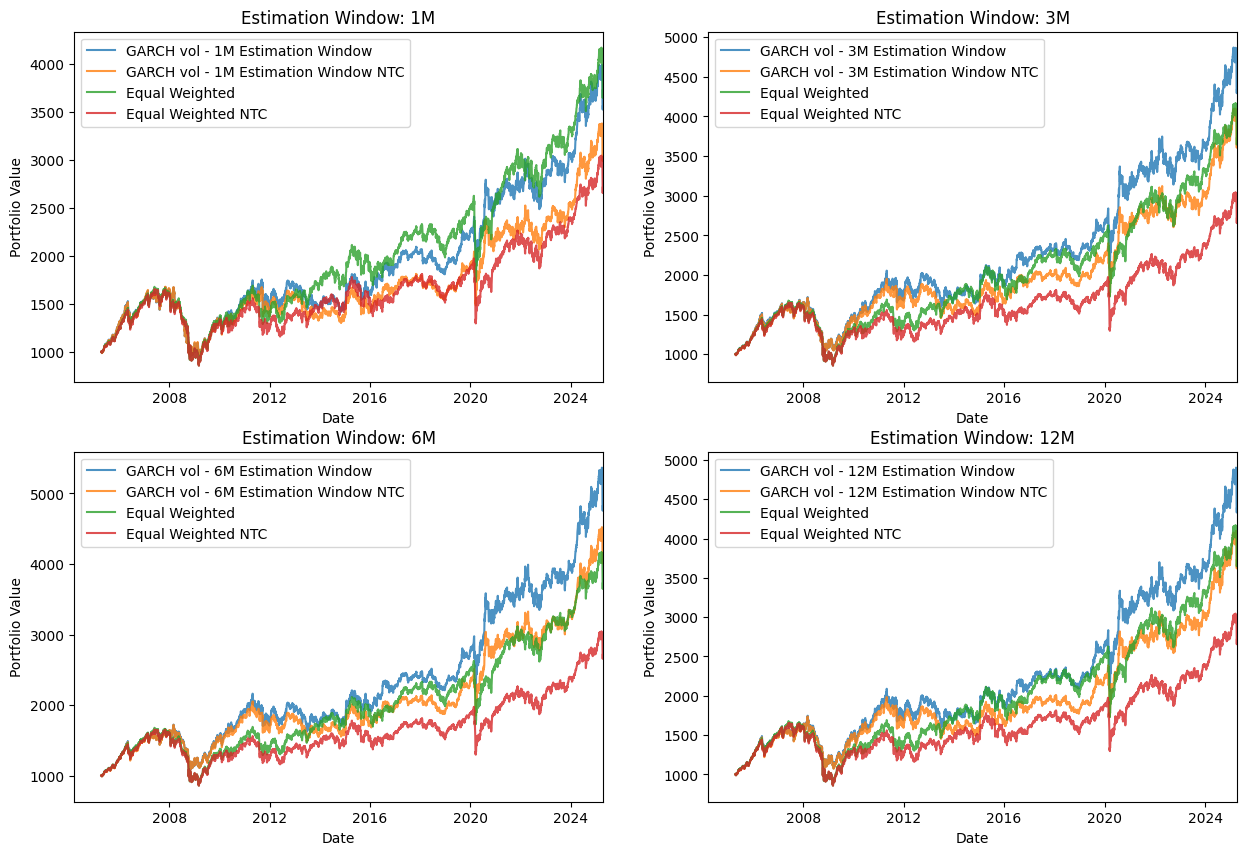

In [63]:
# Plot: 2x2 Grid: For GARCH vol
# Each subplot: a different estimation window (1M, 3M, 6M, 12M)
# Each subplot has 4 lines: strategy, strategy NTC, EW, EW NTC
estimation_windows = [
    ('1M', sim_vol_1MREBAL_1MEST_GARCH, sim_vol_1MREBAL_1MEST_GARCH_NTC),
    ('3M', sim_vol_1MREBAL_3MEST_GARCH, sim_vol_1MREBAL_3MEST_GARCH_NTC),
    ('6M', sim_vol_1MREBAL_6MEST_GARCH, sim_vol_1MREBAL_6MEST_GARCH_NTC),
    ('12M', sim_vol_1MREBAL_12MEST_GARCH, sim_vol_1MREBAL_12MEST_GARCH_NTC),
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axes_flat = axes.flatten()
for idx, (label, sim, sim_ntc) in enumerate(estimation_windows):
    ax = axes_flat[idx]
    ax.plot(sim['Portfolio']['Portfolio value'].index,
            sim['Portfolio']['Portfolio value'],
            label=f'GARCH vol - {label} Estimation Window', alpha=0.8)
    ax.plot(sim_ntc['Portfolio']['Portfolio value'].index,
            sim_ntc['Portfolio']['Portfolio value'],
            label=f'GARCH vol - {label} Estimation Window NTC', alpha=0.8)
    ax.plot(sim_ew_1MREBAL['Portfolio']['Portfolio value'].index,
            sim_ew_1MREBAL['Portfolio']['Portfolio value'],
            label='Equal Weighted', alpha=0.8)
    ax.plot(sim_ew_1MREBAL_NTC['Portfolio']['Portfolio value'].index,
            sim_ew_1MREBAL_NTC['Portfolio']['Portfolio value'],
            label='Equal Weighted NTC', alpha=0.8)
    ax.set_xlim([strategy_ew.start_date, strategy_ew.end_date])
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.set_title(f'Estimation Window: {label}')
    ax.legend()
plt.show()

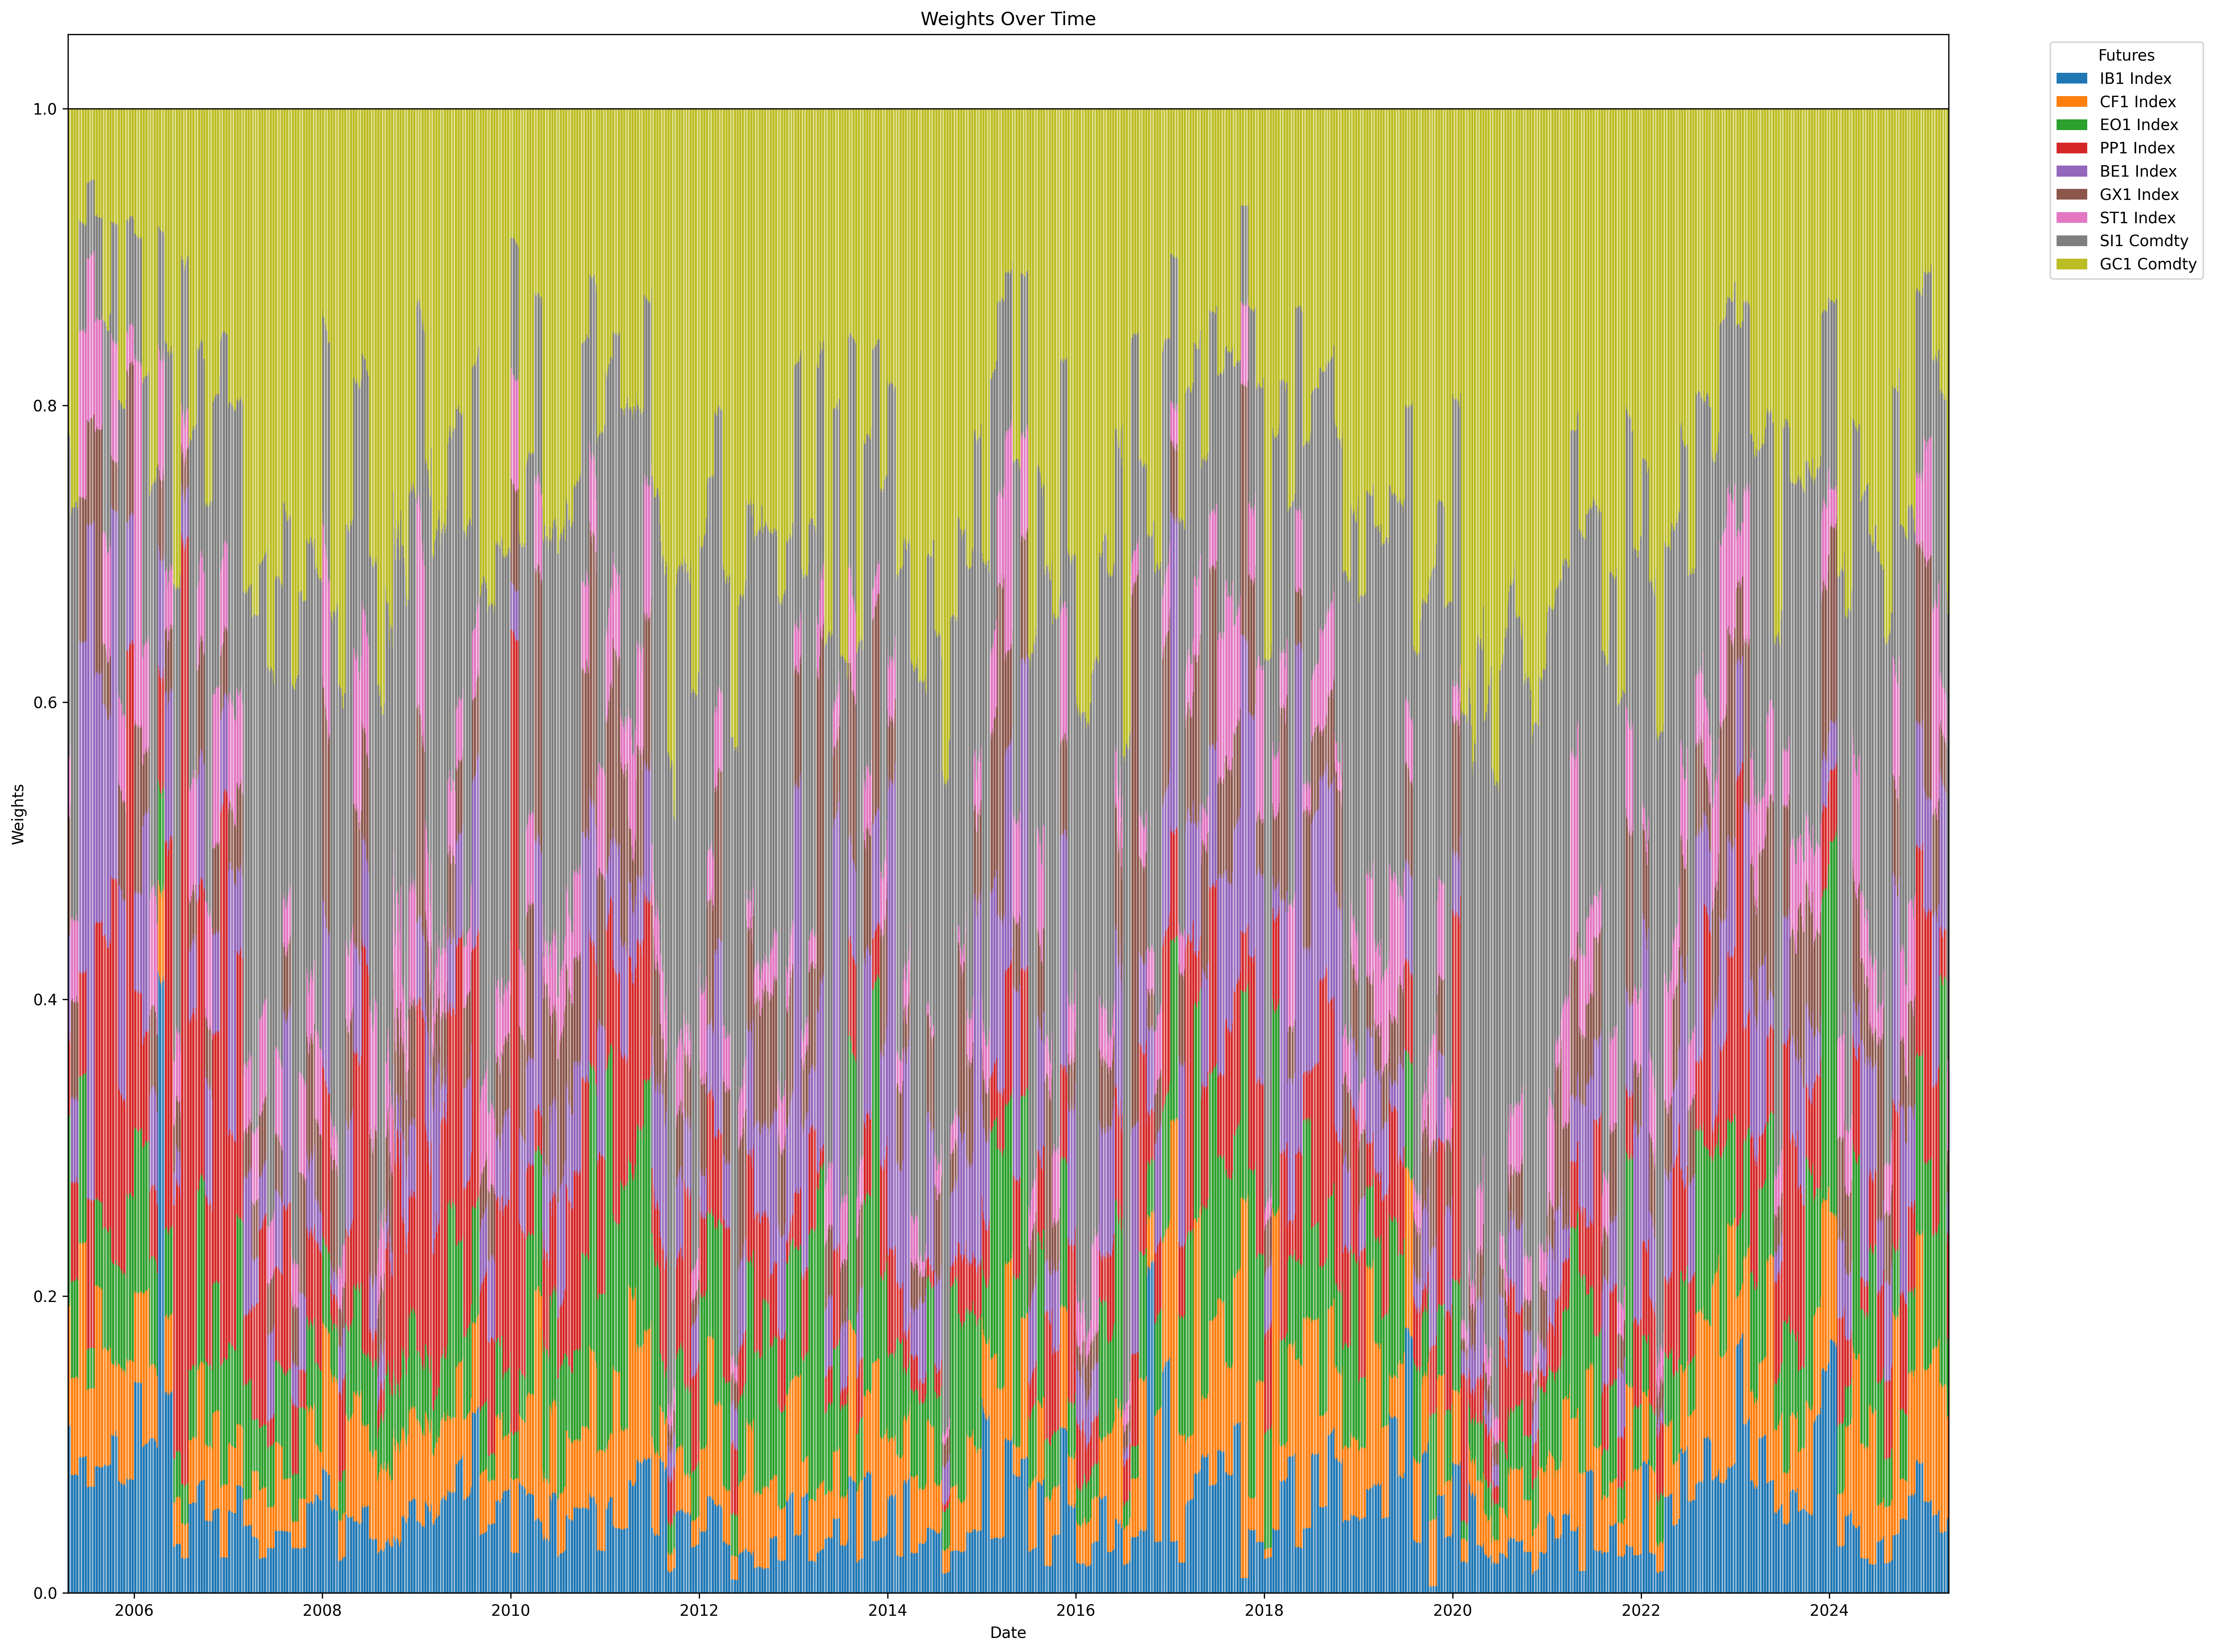

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_1MEST_GARCH_NTC['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_1MEST_NORMVOL['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_3MEST_NORMVOL['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_6MEST_NORMVOL['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_12MEST_NORMVOL['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_1MEST_DOWNVOL['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_3MEST_DOWNVOL['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_6MEST_DOWNVOL['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_12MEST_DOWNVOL['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_1MEST_GARCH['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_3MEST_GARCH['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_6MEST_GARCH['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_vol_1MREBAL_12MEST_GARCH['Weights'], figsize=(20, 15))

In [ ]:
# Plotting weights
pb.plot_weights(sim_ew_1MREBAL['Weights'], figsize=(20, 15))

In [ ]:
# Saving all the simulations
# Individually under outputs/strategies
for simulation in simulation_dict:
    with open(f'outputs/strategies/{simulation}.pkl', 'wb') as f:
        pickle.dump(simulation_dict[simulation], f)
        print(f"Simulation {simulation} saved successfully.")

In [ ]:
# Saving all the simulations all together
with open('outputs/strategies/simulations_all.pkl', 'wb') as f:
    pickle.dump(simulations, f)
    print("All simulations saved successfully.")

In [35]:
print(sim_vol_1MREBAL_1MEST_NORMVOL_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.050393               0.148332      0.339733   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.419509           0.28132                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  


In [36]:
print(sim_vol_1MREBAL_3MEST_NORMVOL_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.054251               0.149697      0.362404   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.449404          0.251808                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  


In [37]:
print(sim_vol_1MREBAL_6MEST_NORMVOL_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.054119               0.150549      0.359479   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.447109          0.241862                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  


In [38]:
print(sim_vol_1MREBAL_12MEST_NORMVOL_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.051271               0.150866      0.339841   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.424196          0.260824                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  


In [39]:
print(sim_vol_1MREBAL_1MEST_DOWNVOL_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.047973               0.147899      0.324366   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.400428           0.28025                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  


In [40]:
print(sim_vol_1MREBAL_3MEST_DOWNVOL_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.053913               0.147582       0.36531   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.451952          0.255674                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  


In [41]:
print(sim_vol_1MREBAL_6MEST_DOWNVOL_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.055776               0.148004      0.376857   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.469306          0.229321                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  


In [42]:
print(sim_vol_1MREBAL_12MEST_DOWNVOL_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.053205               0.148157      0.359112   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.449413           0.24613                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  


In [43]:
print(sim_vol_1MREBAL_1MEST_GARCH_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.056806               0.156218       0.36363   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.443377          0.214037                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  


In [44]:
print(sim_vol_1MREBAL_3MEST_GARCH_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.066814               0.155932      0.428483   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.527802          0.168413                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  


In [45]:
print(sim_vol_1MREBAL_6MEST_GARCH_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.072657               0.154135      0.471382   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.584915          0.146289                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  


In [46]:
print(sim_vol_1MREBAL_12MEST_GARCH_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.067125               0.154686      0.433943   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.534606          0.162589                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  


In [47]:
print(sim_ew_1MREBAL_NTC['Performance'])

            Annualized return  Annualized volatility  Sharpe ratio  \
2005-04-20           0.051189               0.159094      0.321755   

            Sortino ratio  Maximum drawdown  Total transaction costs  \
2005-04-20       0.403214          0.262108                      0.0   

            Total transaction costs due to rolling  \
2005-04-20                                       0   

            Total transaction costs due to rebalancing  
2005-04-20                                         0.0  
